In [385]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Functions we have developed in earlier assignnments

In [386]:
def get_outliers_df(df: pd.DataFrame, ignore_cols = []):
    result = pd.DataFrame()
    ignore_cols = set(ignore_cols)
    for col in df.columns.values:
        if col in ignore_cols:
            continue
        q1, q3 = np.percentile(df[col].to_numpy(), [25,75])
        iqr = q3-q1
        lower_boundary = q1 - (1.5*iqr)
        upper_boundary = q3 + (1.5 * iqr)
        upper_outliers = df.query(f'{col} > {upper_boundary}')[col]
        lower_outliers = df.query(f'{col} < {lower_boundary}')[col]
        result[f'{col}_outliers'] = pd.concat([upper_outliers, lower_outliers])
    return result
        

In [387]:
from sklearn.linear_model import LinearRegression

def random_imputation(df_to_impute: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    copy = df_to_impute.copy()
    for feature in features:
        copy[feature + '_imp'] = copy[feature]
        number_missing = copy[feature].isnull().sum()
        observed_values = copy.loc[copy[feature].notnull(), feature]
        copy.loc[copy[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    return copy

def bootstrapped_stochastic_imputation(df_to_impute: pd.DataFrame, features: list[str]): 
    copy = df_to_impute.copy()
    df = random_imputation(copy, features)
    random_data = pd.DataFrame(columns = ["Ran" + name for name in features])

    for feature in features:
            
        random_data["Ran" + feature] = df[feature + '_imp']
        parameters = list(set(df.columns) - set(features) - {feature + '_imp'})
        
        model = LinearRegression()
        model.fit(X = df[parameters], y = df[feature + '_imp'])
        
        predict = model.predict(df[parameters])
        std_error = (predict[df[feature].notnull()] - df.loc[df[feature].notnull(), feature + '_imp']).std()
        
        random_predict = np.random.normal(size = df[feature].shape[0], 
                                        loc = predict, 
                                        scale = std_error)
        random_data.loc[(df[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(df[feature].isnull()) & 
                                                                                (random_predict > 0)]
    for feature in features:
        copy[feature].fillna(random_data[f'Ran{feature}'],inplace=True)

    return copy


In [388]:

from pandas.io.formats.info import DataFrameInfo

def get_missing_count_ratio_df(df: pd.DataFrame):
    row_count, col_count = df.shape
    info = DataFrameInfo(data = df)
    info_df= pd.DataFrame(
        {'Non-Null Count': info.non_null_counts, 'Dtype': info.dtypes}
    )

    # Calculating missing data per column. 
    info_df['Missing Count'] = row_count- info_df['Non-Null Count']
    info_df['Missing Ratio'] = (info_df['Missing Count'] / row_count).astype(float)
    # Sorting missing data from highest % to lowest %
    return info_df.sort_values(by=['Non-Null Count'], ascending=True)

# 1. Analysis: Frame the problem and look at the big picture.

## Objective
To create a regression model that can predict house sales prices based on different features of the house. This can help people to determine if they are selling their house at the correct price. 

## Framing
This will utilize supervised learning, since we are doing regression to predict the sales price and the sales price is known for each house.

## Performance Measuring
Performance will be measured by different metrics related to regression such as coeffecient of determination ($R^2$) and Mean Squared Error (MSE).

# 2. Get the data

The dataset is from a Kaggle competition and can be found here: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=train.csv.

You must join the competition in order to get access to the data.

In [389]:
data = pd.read_csv('train.csv')

In [390]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [391]:
data.shape

(1460, 81)

In [392]:
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

### 3. Explore the data

In [393]:
eda = data.copy()

In [394]:
eda.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Exploring Missing Values

In [395]:
get_missing_count_ratio_df(eda).head(n=10)

,Non-Null Count,Dtype,Missing Count,Missing Ratio
PoolQC,7,object,1453,0.995205
MiscFeature,54,object,1406,0.963014
Alley,91,object,1369,0.937671
Fence,281,object,1179,0.807534
MasVnrType,588,object,872,0.597260
FireplaceQu,770,object,690,0.472603
LotFrontage,1201,float64,259,0.177397
GarageYrBlt,1379,float64,81,0.055479
GarageType,1379,object,81,0.055479
GarageFinish,1379,object,81,0.055479


We see that there are features where almost all the data is missing such as PoolQC, MiscFeature, Alley and more. We will now look further into the features where a signifcant part of the data is missing to attempt to get an understanding of why they are missing

Looking at the rows where it is not null

In [396]:
eda.loc[~eda["PoolQC"].isna()]["PoolQC"].value_counts()

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64

Only 7 rows have a value for Pool Quality, so the missing values might be because the house does not have a pool. We can verify this by looking at the PoolArea feature for the rows where PoolQC is missing.

In [397]:
eda.loc[eda["PoolQC"].isna()][["PoolQC", "PoolArea"]]

,PoolQC,PoolArea
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
1455,NaN,0
1456,NaN,0
1457,NaN,0
1458,NaN,0


In [398]:
eda.loc[eda["PoolQC"].isna()][["PoolQC", "PoolArea"]].query("PoolArea > 0")

,PoolQC,PoolArea


PoolQC is missing because they do not have a pool. According to `data_description.txt` this should have been set to `NA`, so we can replace the missing values with `NA` during preprocessing.

Now we will take a look at `MiscFeature`. `MiscFeature` is Miscellaneous feature not covered in other categories such as Elevator, 2nd Garage, Tennis Court and more.

In [399]:
eda.loc[~eda["MiscFeature"].isna()]["MiscFeature"].value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

This feature has missing values because the house might not have any Miscellaneous features. We will verify this by checkign the `MiscVal` feature that indicates the value of the feature in dollars. 

In [400]:
eda.loc[eda["MiscFeature"].isna()][["MiscFeature", "MiscVal"]]

,MiscFeature,MiscVal
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
1454,NaN,0
1455,NaN,0
1456,NaN,0
1458,NaN,0


In [401]:
eda.loc[eda["MiscFeature"].isna()][["MiscFeature", "MiscVal"]].query("MiscVal > 0")

,MiscFeature,MiscVal


It would seem like `MiscFeature` has missing values because the house has no Miscellaneous features and they have not been put down as `NA` as specified in `data_description.txt`

In [402]:
eda.loc[~eda["Alley"].isna()]["Alley"].value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

We notice that `Alley` also should have been classified as NA but has been put down as null instead.

The `Fence`, `MasVnrType`, `FireplaceQu` feature has missing values for the same reason as `PoolQC`, `MiscFeatures` and `Alley`

## Exploring Outliers

We first select all numerical features

In [403]:
eda_numerical = eda.select_dtypes([float, int])

In [404]:
import math
def boxplot_columns(df: pd.DataFrame, plots: int):
    df = df.loc[:, df.max().sort_values(ascending=False).index]
    column_bins = np.array(list(map(lambda x: math.floor(x), np.linspace(0, len(df.columns.values), num=plots))))
    prev = 0
    curr = 1
    for column_idx in column_bins[1:]:
        # curr = column_idx if curr == 0 else column_idx - 1
        curr = column_idx 
        plt.figure(figsize=(15,10))
        df[df.columns.values[prev:curr]].boxplot()
        plt.show()
        prev = curr

In [405]:
import math
def plot_histograms(df: pd.DataFrame, plots: int = 5):
    df = df.loc[:, df.max().sort_values(ascending=False).index]
    column_bins = np.array(list(map(lambda x: math.floor(x), np.linspace(0, len(df.columns.values), num=plots))))
    prev = 0
    curr = 1
    for column_idx in column_bins[1:]:
        # curr = column_idx if curr == 0 else column_idx - 1
        curr = column_idx
        plt.figure(figsize=(15,10))
        df[df.columns.values[prev:curr]].hist()
        plt.show()
        prev = curr

### Looking at the boxplots for all numerical features

The target is `SalePrice`, so we drop that before plotting.

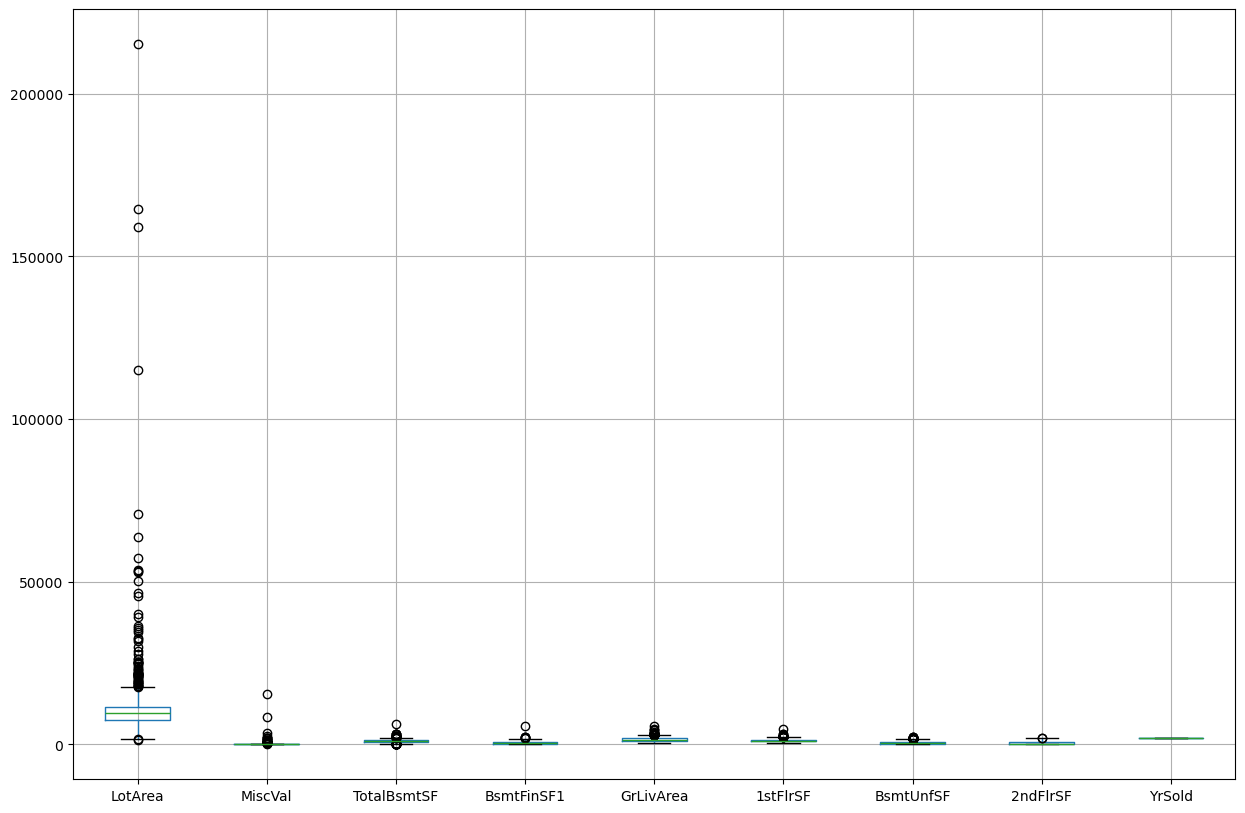

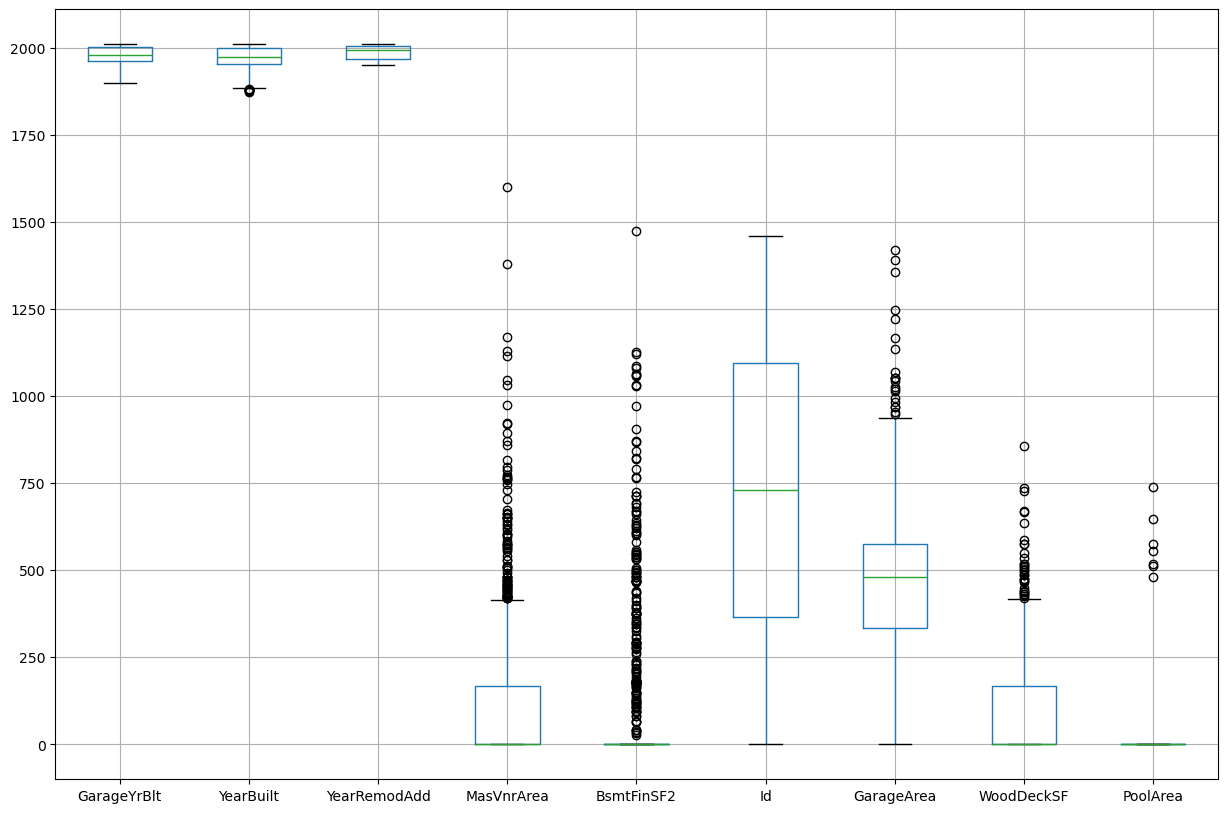

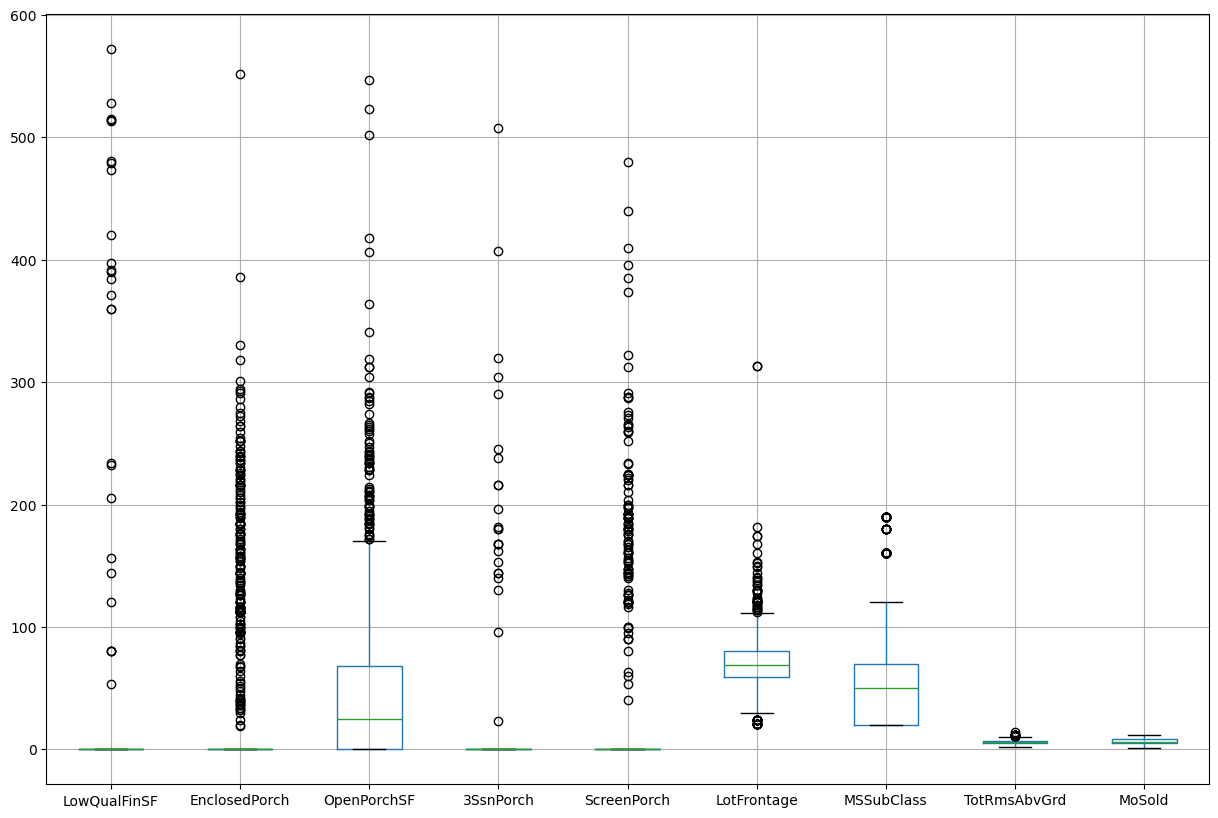

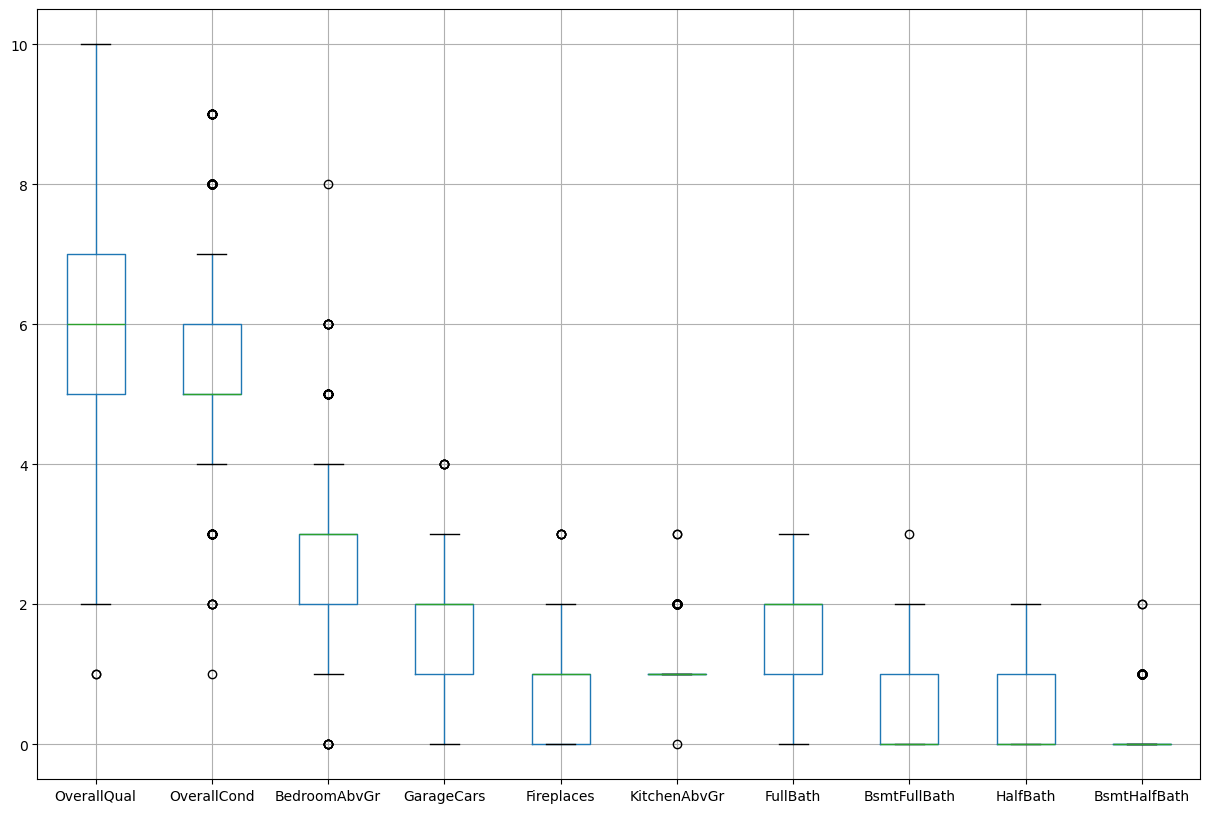

In [406]:
boxplot_columns(eda_numerical.drop('SalePrice', axis=1), 5)

Initially when looking at the boxplots, we notice that a lot of the features have outliers, including `LotArea, MiscVAl, TotalBsmtSF, BsmtFinSF1, GrLivArea, lstFlSF, BsmtUnfSF, MasVnrArea, BsmtFinSF2, GarageArea, WoodDeckSF, PoolArea, LowQualFinSF, EnclosedPorc, OpenPorchSF, 3SsnPorch, ScreenPorch, LotFrontage, MSSubClass, TotRmsAbcGrid, OverallCond, BedRoomAbvGr, GarageCars, Fireplaces, KitchenAbvGr, BsmtFullBath, BstmfHalfBath`. At this moment, we are unsure if they are natural outliers or if they represent data entry errors or processing errors. We take a closer look to see if we can learn more about the outliers. Some features are rare for common houses, meaning when a certain price class is reached the feature suddently becomes common. 

A lot of the features with outliers have IQR close to 0 and then outliers above the upper tick. This can be explained by many houses does not have the feature that the feature is describing, thus making the other houses that actually have the features to outliers. E.g. Most houses do not have an `EnclosedPorch`, but the few that do, will then be outliers. This is related to the points we made above. Some features are also related to the price 

Out of the boxplots above, we can see that many features have outliers, but we are not sure if they are natural outliers or if they are data entry errors or processing errors. We will take a closer look at the features with outliers to see if we can learn more about them. 

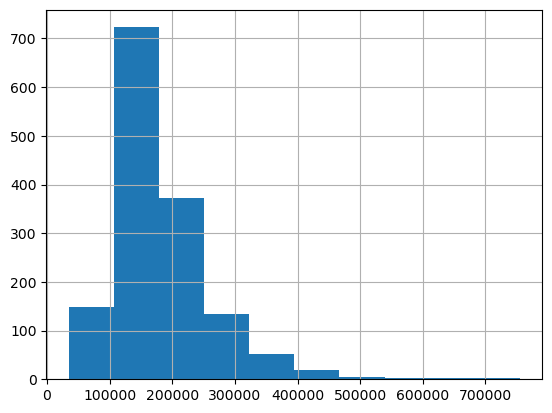

In [407]:
eda_numerical['SalePrice'].hist()
plt.show()

When looking at the distribution of the SalePrice it looks positive skewed, which would seem naturally. Only a few percentage of the houses are very expensive, while most houses are in the lower to middle class.
This can also explain some of our outliers. They are natural outliers, because the feature maybe is inherently tied to the price range of the house. We can verify this by taking a look at the correlation matrix and compare the distribution of one of the features that is higly correlated to the Sale Price. 

We will try to see plot the correlations to see 

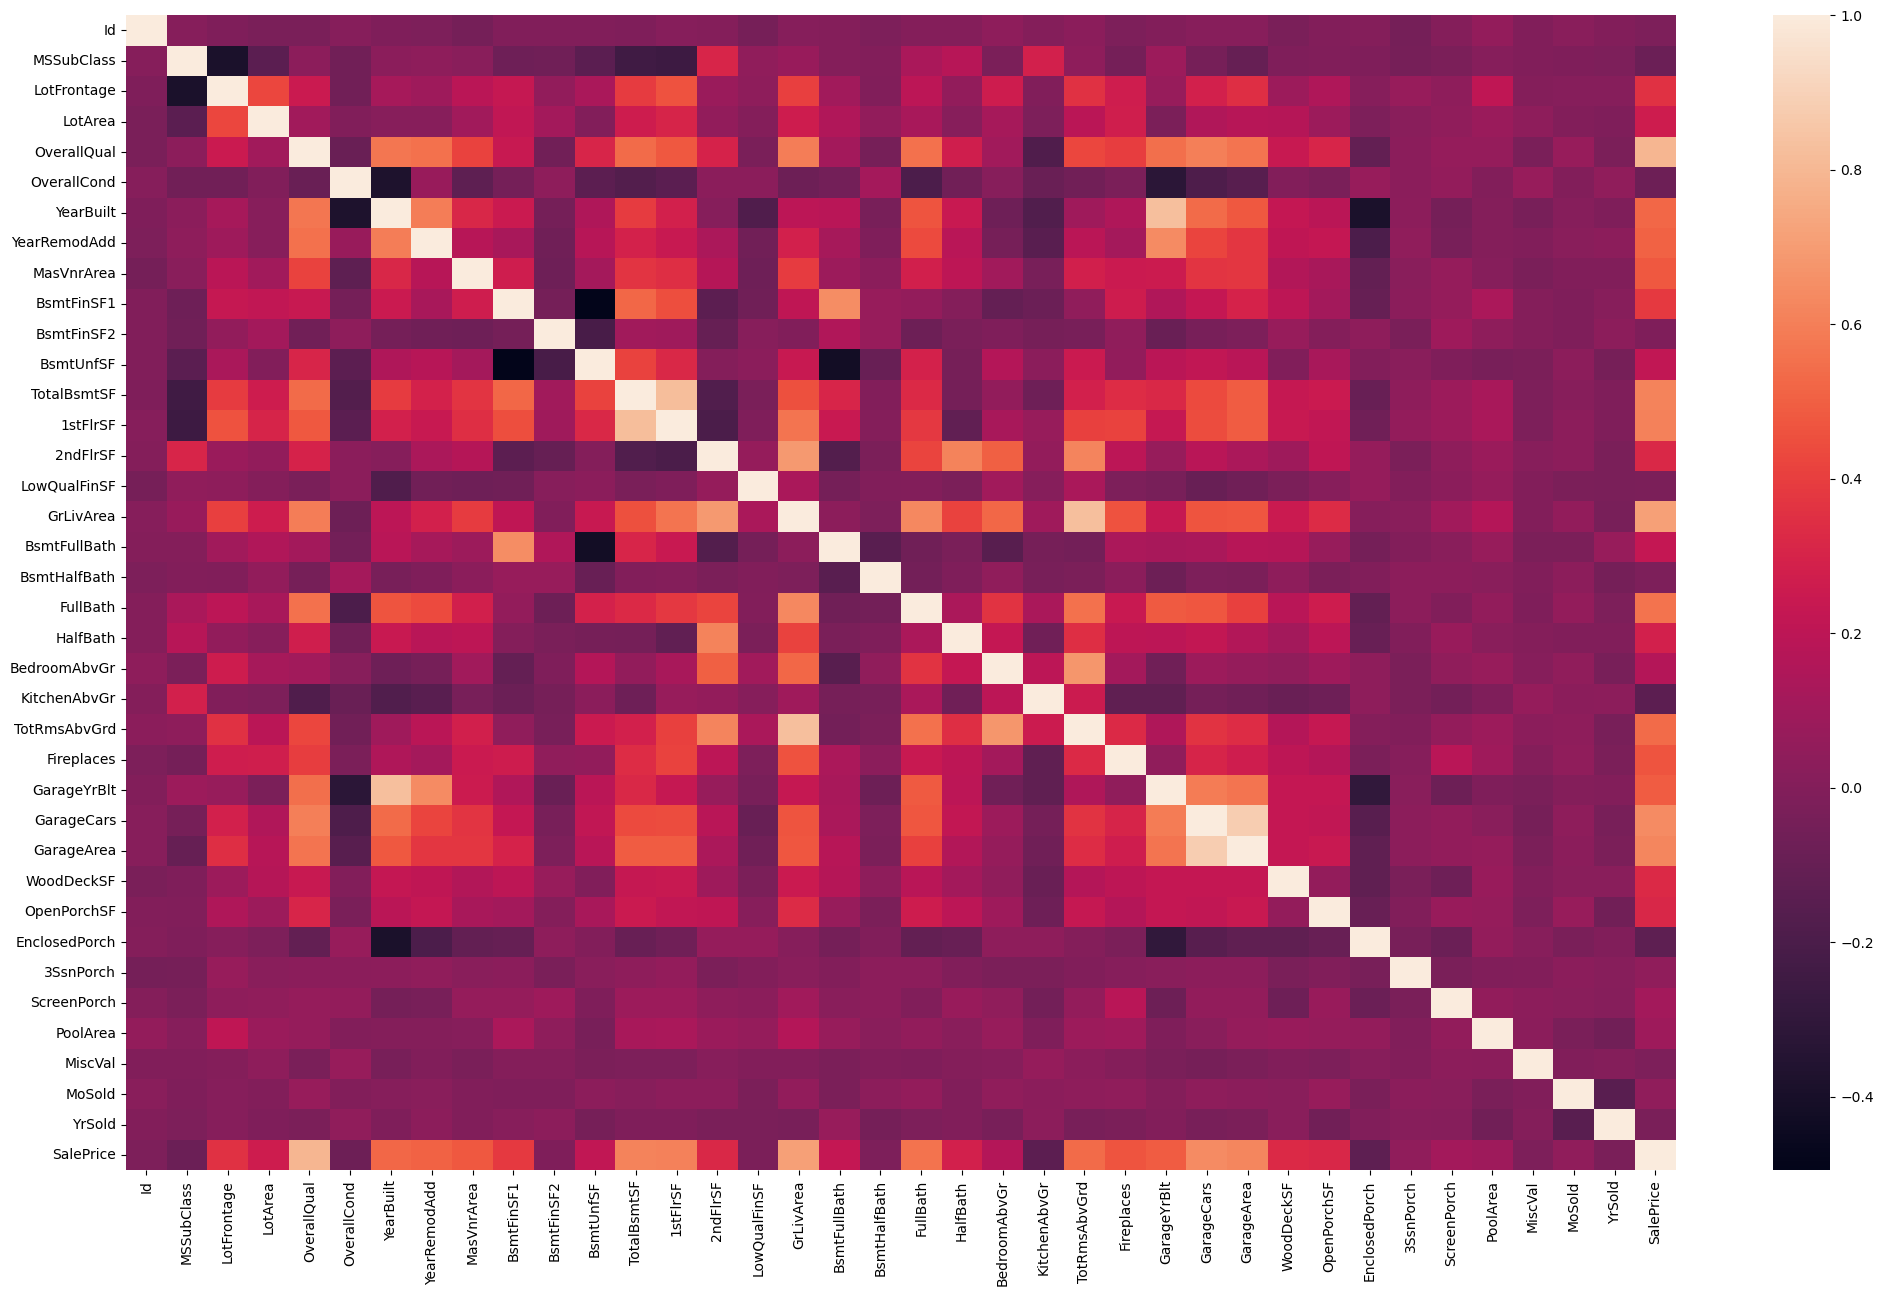

In [408]:
import seaborn as sns
corr = eda_numerical.corr()
plt.figure(figsize=(25,15))

sns.heatmap(corr)
plt.show()


Here we see that `GrLivArea` is positively correlated with `SalePrice`, so we would assume that `GrLivArea` follow a similar distribution to the `SalePrice`, thus we can assume that the `GrLivArea` outliers are natural.  
The same reasoning can be applied to the other features with outliers - They are either rare features of a house such as `EnclosedPorch` or they are correlated to the price class of the house such as `GrLivArea` and `OverallQual`

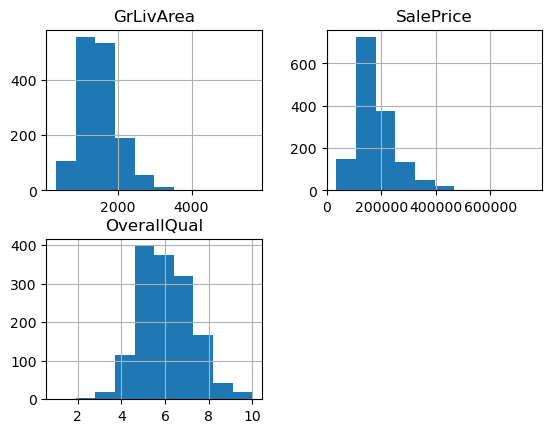

In [409]:
eda_numerical[['GrLivArea', 'SalePrice', 'OverallQual']].hist()
plt.show()

From the observations we have made, we deem the outliers to be natural and we will not remove them from the dataset.

### Distributions of the features.

<Figure size 1500x1000 with 0 Axes>

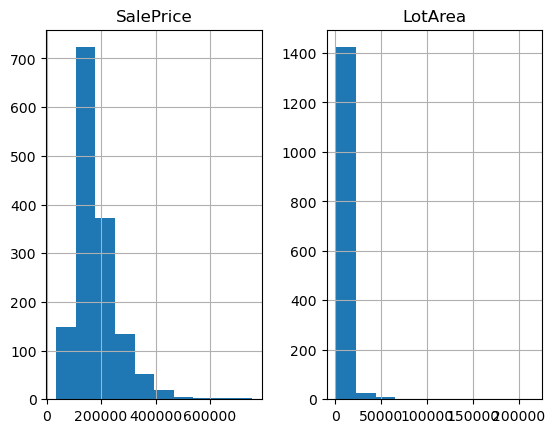

<Figure size 1500x1000 with 0 Axes>

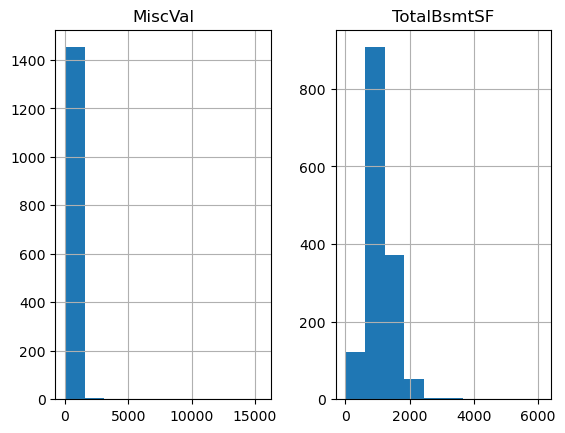

<Figure size 1500x1000 with 0 Axes>

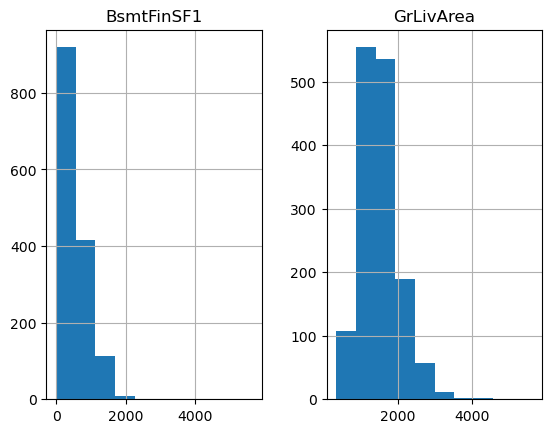

<Figure size 1500x1000 with 0 Axes>

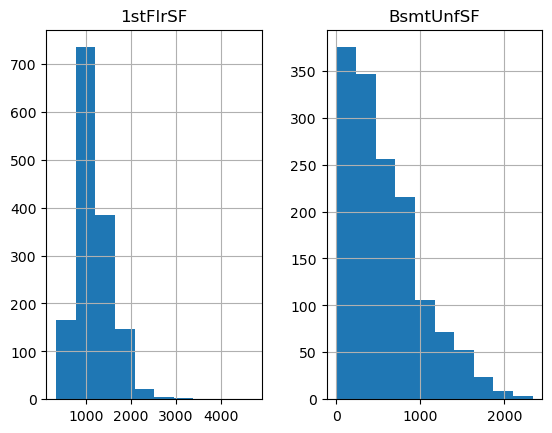

<Figure size 1500x1000 with 0 Axes>

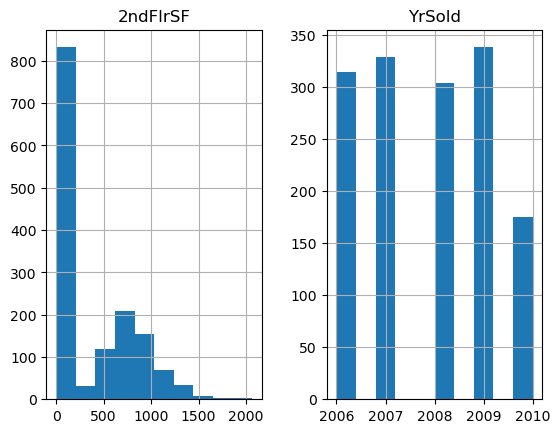

<Figure size 1500x1000 with 0 Axes>

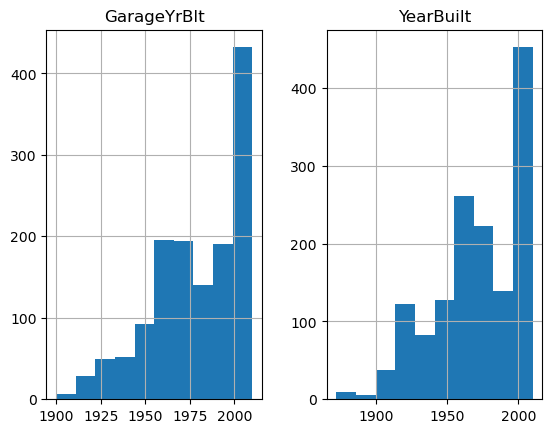

<Figure size 1500x1000 with 0 Axes>

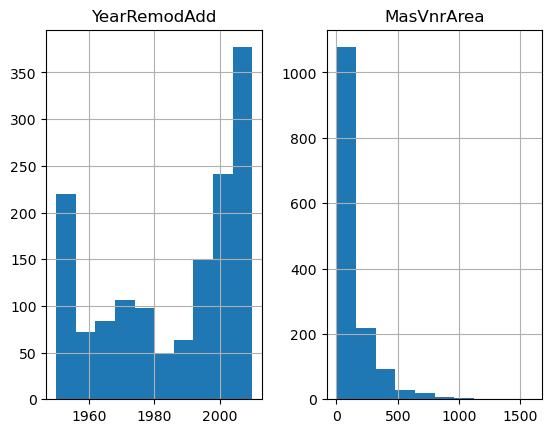

<Figure size 1500x1000 with 0 Axes>

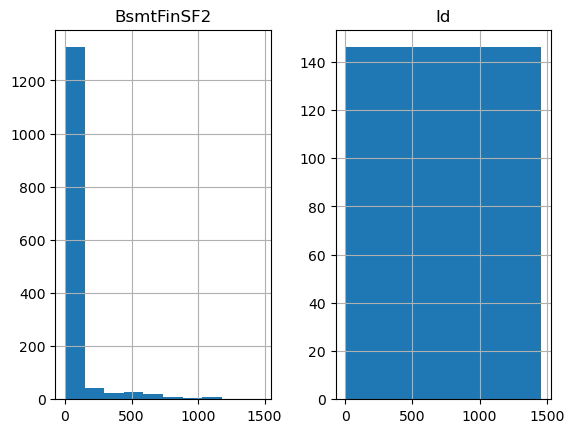

<Figure size 1500x1000 with 0 Axes>

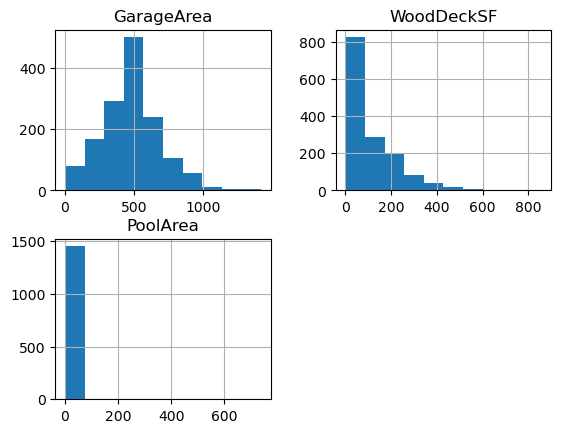

<Figure size 1500x1000 with 0 Axes>

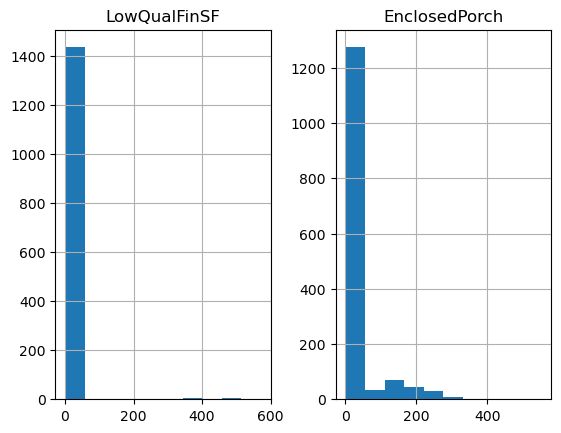

<Figure size 1500x1000 with 0 Axes>

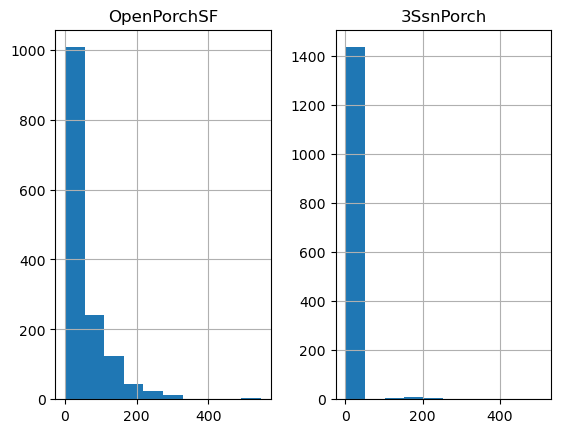

<Figure size 1500x1000 with 0 Axes>

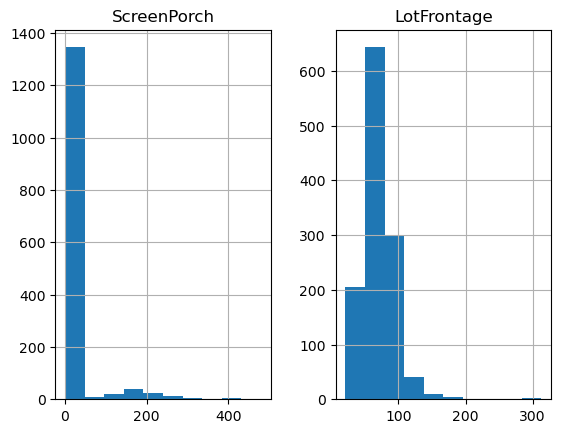

<Figure size 1500x1000 with 0 Axes>

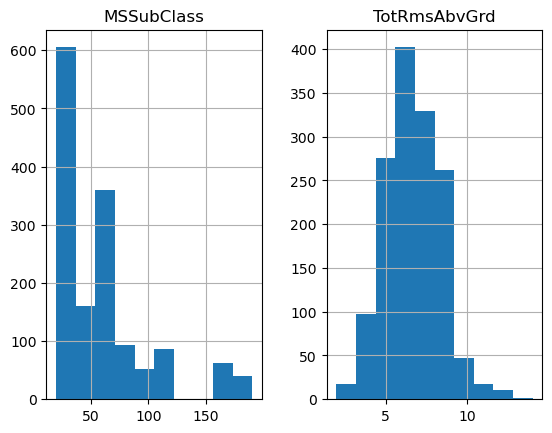

<Figure size 1500x1000 with 0 Axes>

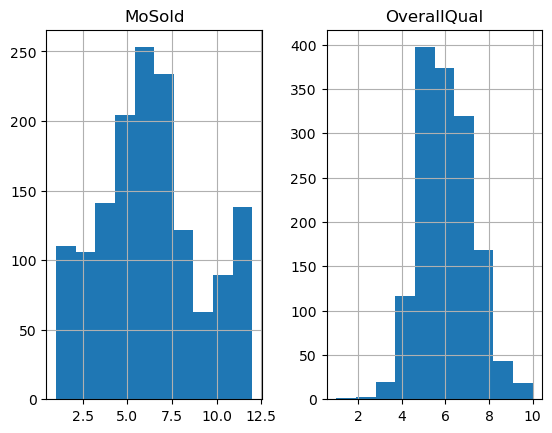

<Figure size 1500x1000 with 0 Axes>

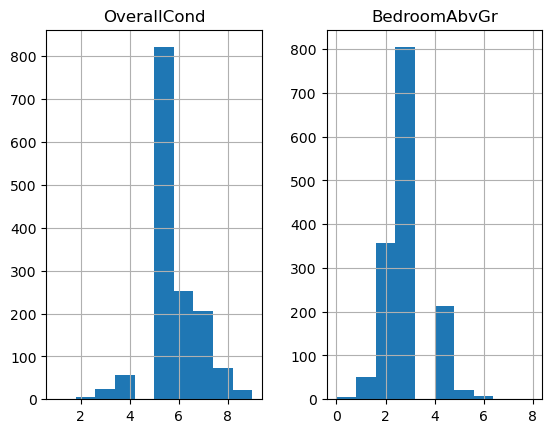

<Figure size 1500x1000 with 0 Axes>

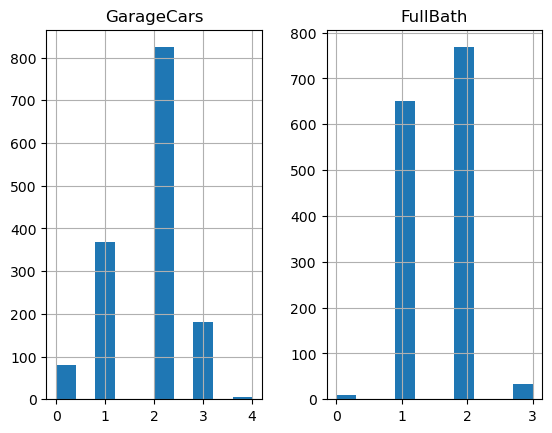

<Figure size 1500x1000 with 0 Axes>

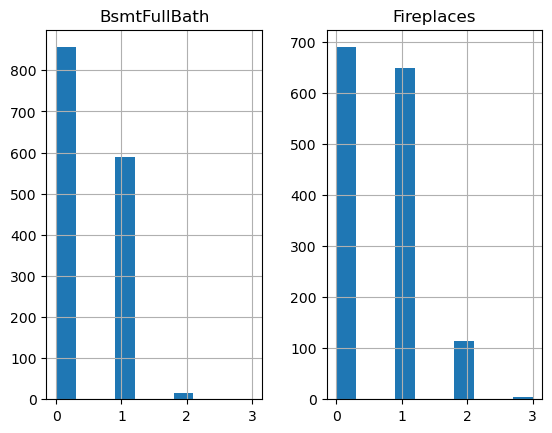

<Figure size 1500x1000 with 0 Axes>

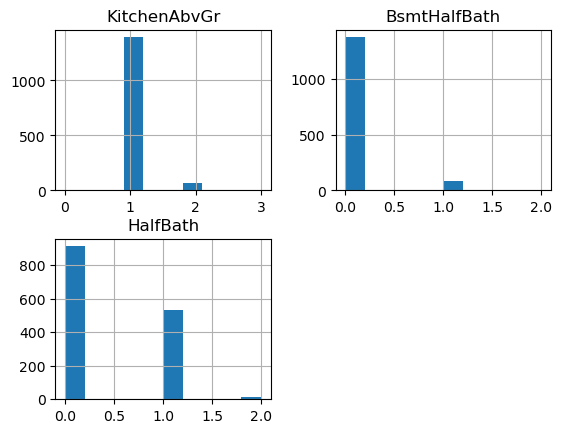

In [410]:
plot_histograms(eda_numerical, plots=19)

We notice that some of the features are positive-skwewed. Of the postiive-skewed features, some of them are very positive-skewed such as `WoodDeckSF` and `OpenPorchSF`, while some of them are only slightly positive-skewed. For the very positive-skewed features we can apply a log(n) transformation and for the data that is only slightly positive-skewed we can apply a sqrt(n) transformation. 

When training the models, we will first train the model without the transformations and then after apply the transformations and retrain, to see if it makes an siginificant impact. 

## Target

The target / y in this dataset is the `SalePrice` features. 

# 4. Prepare the data

In [411]:
data_cleansed = data.copy()

## Data Cleaning

We will clean missing data we identified in the exploratory data analysis. The missing data was caused by `NA` being loaded as nulls, so we will replace the missing data with `NA` or something similar. 

In [412]:
get_missing_count_ratio_df(eda).head(n=20)

,Non-Null Count,Dtype,Missing Count,Missing Ratio
PoolQC,7,object,1453,0.995205
MiscFeature,54,object,1406,0.963014
Alley,91,object,1369,0.937671
Fence,281,object,1179,0.807534
MasVnrType,588,object,872,0.597260
FireplaceQu,770,object,690,0.472603
LotFrontage,1201,float64,259,0.177397
GarageYrBlt,1379,float64,81,0.055479
GarageType,1379,object,81,0.055479
GarageFinish,1379,object,81,0.055479


In [413]:
# Fills it nulls with NA string for the features where they can have a NA category according to data_description.txt
def fill_missing_categorical_data(df: pd.DataFrame, features: list[str] = ['PoolQC', 'MiscFeature', 'Alley','Fence', 'MasVnrType', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond','GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']) -> pd.DataFrame:
    for feature in features:
        df[feature] = df[feature].fillna(f'NA_{feature}')
    return df

# Fills out nulls with 0 for features where they are null because they are missing, e.g. for MasVnrArea, where the house might not have Masonry Veneer, so the area should be 0.
def fill_missing_numerical_data(df: pd.DataFrame, features: list[str] = ['MasVnrArea', 'LotFrontage']) -> pd.DataFrame:
    for feature in features:
        df[feature] = df[feature].fillna(0)
    return df



In [414]:
data_cleansed = fill_missing_numerical_data(fill_missing_categorical_data(data_cleansed))
data_cleansed = data_cleansed.dropna(subset=['Electrical'])

In [415]:
get_missing_count_ratio_df(data_cleansed).head(n=10)

,Non-Null Count,Dtype,Missing Count,Missing Ratio
GarageYrBlt,1378,float64,81,0.055517
FireplaceQu,1459,object,0,0.000000
Fireplaces,1459,int64,0,0.000000
Functional,1459,object,0,0.000000
TotRmsAbvGrd,1459,int64,0,0.000000
KitchenQual,1459,object,0,0.000000
KitchenAbvGr,1459,int64,0,0.000000
BedroomAbvGr,1459,int64,0,0.000000
GarageType,1459,object,0,0.000000
Id,1459,int64,0,0.000000


We know from the correlation matrix that GarageYrBlt is highly correlated with BltYr, so we handle the missing values by dropping the columns entirely in the feature selection section 

## Feature Selection

Dropping `GarageYrBlt` and `Id` features

In [416]:
data_cleansed = data_cleansed.drop(columns=['GarageYrBlt', 'Id'], axis=1)
data_cleansed

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NA_Alley,Reg,Lvl,AllPub,Inside,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NA_Alley,Reg,Lvl,AllPub,FR2,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NA_Alley,IR1,Lvl,AllPub,Inside,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NA_Alley,IR1,Lvl,AllPub,Corner,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NA_Alley,IR1,Lvl,AllPub,FR2,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NA_Alley,Reg,Lvl,AllPub,Inside,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NA_Alley,Reg,Lvl,AllPub,Inside,...,0,NA_PoolQC,MnPrv,NA_MiscFeature,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NA_Alley,Reg,Lvl,AllPub,Inside,...,0,NA_PoolQC,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NA_Alley,Reg,Lvl,AllPub,Inside,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,4,2010,WD,Normal,142125


In [417]:
data_cleansed_numerical = data_cleansed.select_dtypes(include=['int', 'float'])

In [418]:
corr = data_cleansed_numerical.drop('SalePrice', axis=1, inplace=False).corr()
corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.215226,-0.139766,0.032936,-0.059134,0.027435,0.040199,0.023792,-0.069501,-0.065549,...,-0.098558,-0.012598,-0.005838,-0.011904,-0.043786,-0.025932,0.008309,-0.007651,-0.013404,-0.021461
LotFrontage,-0.215226,1.000000,0.100770,0.176853,-0.053308,0.036523,0.078396,0.105202,0.076996,-0.009225,...,0.201599,-0.016795,0.069836,0.027478,0.023536,0.023053,0.114135,-0.059583,0.019094,-0.012137
LotArea,-0.139766,0.100770,1.000000,0.105786,-0.005665,0.014296,0.013852,0.103302,0.214121,0.111158,...,0.180392,0.171701,0.084751,-0.018360,0.020417,0.043147,0.077669,0.038063,0.001179,-0.014254
OverallQual,0.032936,0.176853,0.105786,1.000000,-0.092243,0.573334,0.551605,0.407075,0.239265,-0.059291,...,0.561980,0.239000,0.308554,-0.114162,0.030314,0.064755,0.065143,-0.031461,0.070570,-0.027277
OverallCond,-0.059134,-0.053308,-0.005665,-0.092243,1.000000,-0.375780,0.074158,-0.125922,-0.046595,0.040132,...,-0.151662,-0.003318,-0.032847,0.070238,0.025465,0.054721,-0.002009,0.068752,-0.003685,0.044003
YearBuilt,0.027435,0.036523,0.014296,0.573334,-0.375780,1.000000,0.592512,0.312227,0.250465,-0.048903,...,0.479460,0.224946,0.189359,-0.387177,0.031461,-0.050175,0.005006,-0.034330,0.012791,-0.013733
YearRemodAdd,0.040199,0.078396,0.013852,0.551605,0.074158,0.592512,1.000000,0.177038,0.129259,-0.067575,...,0.372012,0.205773,0.226944,-0.193740,0.045389,-0.038558,0.005882,-0.010226,0.021860,0.035656
MasVnrArea,0.023792,0.105202,0.103302,0.407075,-0.125922,0.312227,0.177038,1.000000,0.260989,-0.071453,...,0.370807,0.160026,0.122287,-0.110065,0.019100,0.062151,0.011903,-0.029550,-0.006916,-0.008263
BsmtFinSF1,-0.069501,0.076996,0.214121,0.239265,-0.046595,0.250465,0.129259,0.260989,1.000000,-0.050328,...,0.296851,0.204403,0.111346,-0.102581,0.026382,0.061862,0.140491,0.003514,-0.016060,0.014456
BsmtFinSF2,-0.065549,-0.009225,0.111158,-0.059291,0.040132,-0.048903,-0.067575,-0.071453,-0.050328,1.000000,...,-0.018295,0.067909,0.002954,0.036475,-0.030017,0.088823,0.041697,0.004923,-0.015309,0.031734


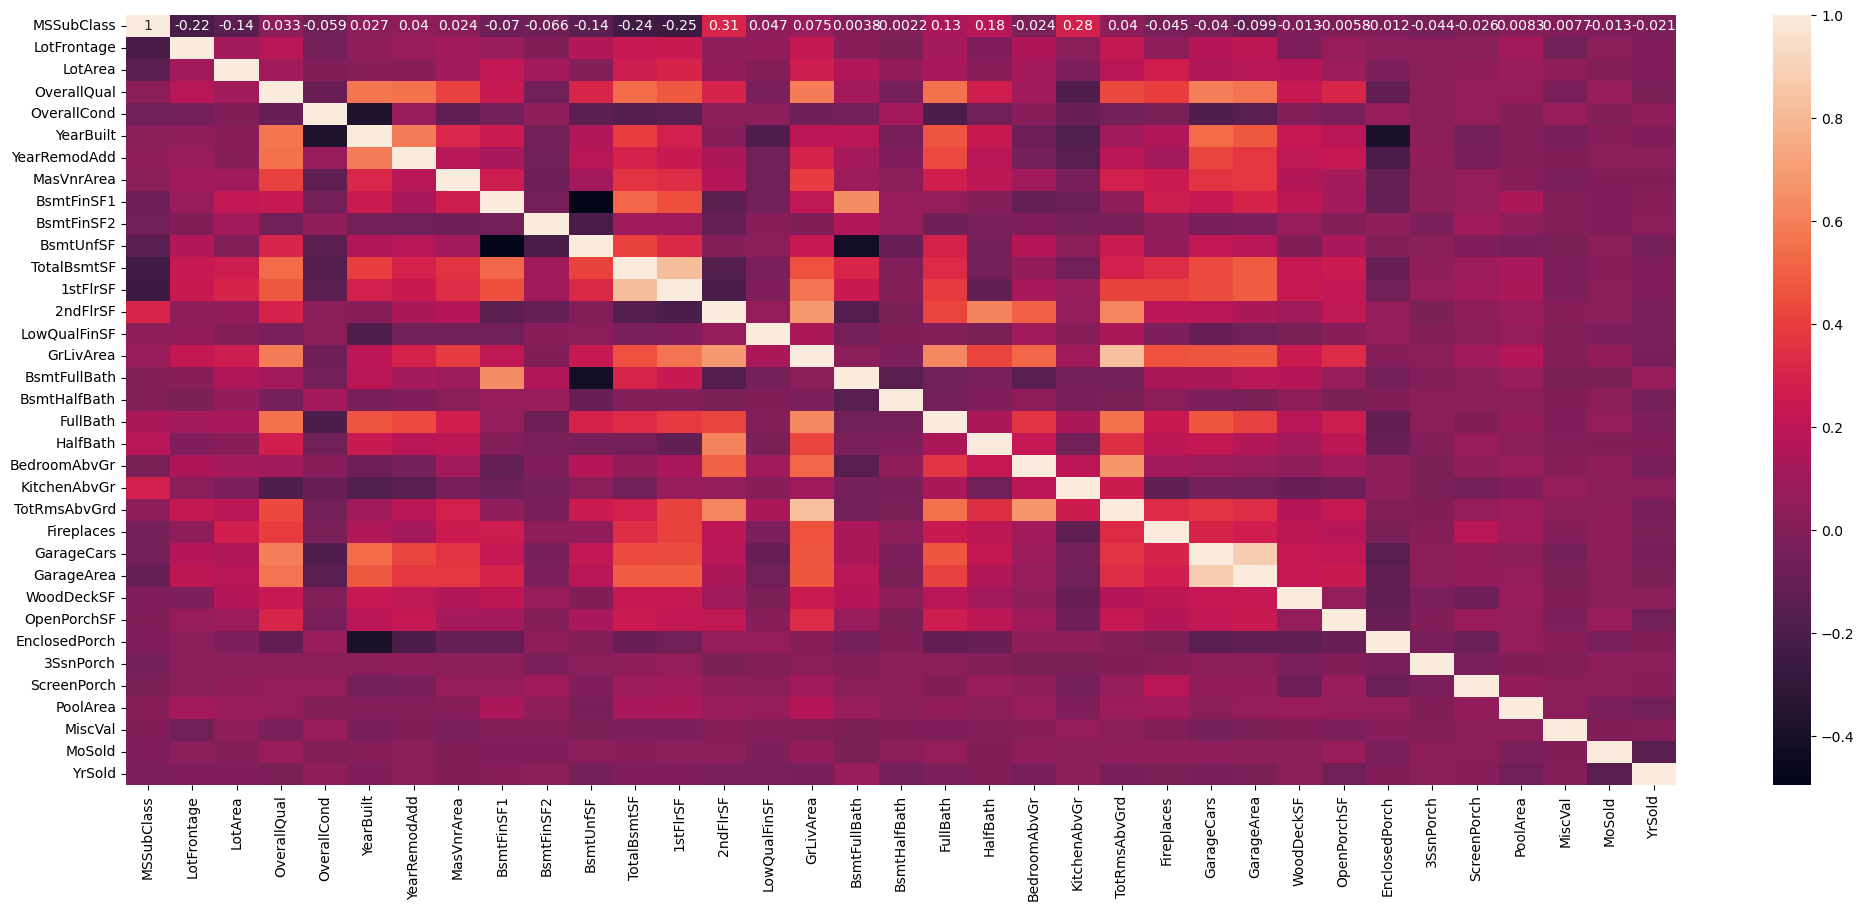

In [419]:
plt.figure(figsize=(25,10))
sns.heatmap(corr, annot=True)
plt.show()

We find all the features that are highly correlated, i.e. correlation >0.7 or correlation < -0.7

In [420]:
corr_map = {}
for feature in data_cleansed_numerical.drop('SalePrice',axis=1):
    corr_values = corr[feature].sort_values(ascending=False)
    for idx, value in  corr_values.items():
        if idx == feature:
            continue
        if value > 0.7 or value < -0.7:
            if feature not in corr_map:
                corr_map[feature] = [idx]
            else:
                corr_map[feature].append(idx)
corr_map

{'TotalBsmtSF': ['1stFlrSF'],
 '1stFlrSF': ['TotalBsmtSF'],
 'GrLivArea': ['TotRmsAbvGrd'],
 'TotRmsAbvGrd': ['GrLivArea'],
 'GarageCars': ['GarageArea'],
 'GarageArea': ['GarageCars']}

The features that are highly correlated, are only highly correlated with one other feature. We just choose which one to drop arbritarily.

In [421]:
data_cleansed.drop(columns=['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea'])

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NA_Alley,Reg,Lvl,AllPub,Inside,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NA_Alley,Reg,Lvl,AllPub,FR2,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NA_Alley,IR1,Lvl,AllPub,Inside,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NA_Alley,IR1,Lvl,AllPub,Corner,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NA_Alley,IR1,Lvl,AllPub,FR2,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NA_Alley,Reg,Lvl,AllPub,Inside,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NA_Alley,Reg,Lvl,AllPub,Inside,...,0,NA_PoolQC,MnPrv,NA_MiscFeature,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NA_Alley,Reg,Lvl,AllPub,Inside,...,0,NA_PoolQC,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NA_Alley,Reg,Lvl,AllPub,Inside,...,0,NA_PoolQC,NA_Fence,NA_MiscFeature,0,4,2010,WD,Normal,142125


## Feature Engineering

We have a mix of categorical and numerical features. 

First we onehot encode the categorical features.

In [422]:
def onehot_encode_categorical_features(df: pd.DataFrame) -> pd.DataFrame:
    return pd.get_dummies(df, dtype='int')

In [423]:
data_cleansed = onehot_encode_categorical_features(data_cleansed)
data_cleansed

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,1,0,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,1,0,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,1,0,0,0,0,1,0


Currenty our dataset has 302 features and we would like to reduce the amount of features before training the models. We can reduce the features by manually dropping highly correlated features using the correlation matrix, by Lasso Regression or by using PCA.  

In [424]:
def get_Xy(df: pd.DataFrame):
    return df.drop('SalePrice', axis=1), df['SalePrice']

We assume Lasso Regression is better suited for the task, since PCA only reduces feature space by retaining the maximum variance, while Lasso Regression performs feature selection based by feature importance. Features that do not have high importance in regards to the target wills shrink to zero, leaving the important features back. 

Before we perform Lasso Regression, we must first scale the data to ensure all features are regularized correctly.

## Feature Scaling

To scale the data we use a Standard Scaler, since it is less sensitive to outliers.

In [425]:
X,y = get_Xy(data_cleansed)

In [426]:
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()

X_scaled = standardScaler.fit_transform(X)


In [427]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

hyperparam_grid = {'alpha': [0.01, 0.1, 1, 5, 10, 20], 'fit_intercept': [True, False]}
lasso_gs = GridSearchCV(estimator=Lasso(), param_grid=hyperparam_grid)
lasso_gs.fit(X_scaled,y)

c:\Users\Bruger\anaconda3\envs\ml_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.400e+11, tolerance: 7.592e+08
  model = cd_fast.enet_coordinate_descent(


c:\Users\Bruger\anaconda3\envs\ml_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e+11, tolerance: 7.288e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\Bruger\anaconda3\envs\ml_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e+11, tolerance: 6.990e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\Bruger\anaconda3\envs\ml_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1, 5, 10, 20],
                         'fit_intercept': [True, False]})

In [428]:
feature_names = X.columns
feature_names

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=301)

In [429]:
lasso_estimator = lasso_gs.best_estimator_
lasso_estimator.coef_


array([-2.37708033e+03,  2.07647373e+02,  7.09480453e+03,  9.35382574e+03,
        6.35364753e+03,  9.15429529e+03,  1.98303752e+03,  3.76642759e+03,
        7.95370862e+03,  1.53590775e+03, -0.00000000e+00,  8.48414237e+03,
        8.88464545e+03,  1.66905982e+04, -1.28418833e+03,  1.20215330e+04,
        7.58371049e+02, -1.16923749e+02,  1.92561220e+03,  8.53566999e+02,
       -2.78058412e+03, -2.93227392e+03,  2.80011032e+03,  3.83611227e+03,
        3.08853119e+03,  3.79512075e+03,  1.88296008e+03,  1.33789930e+02,
        8.28548983e+01,  9.62382029e+02,  1.92733835e+03,  1.76574480e+04,
        0.00000000e+00, -1.19246768e+03, -6.41342054e+02, -2.13380881e+03,
        1.47579126e+03, -2.40996376e+02,  0.00000000e+00, -1.27649183e+03,
       -2.05481489e+03,  1.19686760e-13,  6.30603422e+01, -1.64636443e+02,
        0.00000000e+00, -7.71790705e+02,  4.89966398e+02,  3.11419737e+02,
        0.00000000e+00, -1.12037875e+03,  4.00904260e+02, -2.46636801e+03,
        0.00000000e+00,  

In [430]:
import warnings
warnings.filterwarnings("ignore")

selected_features_df = pd.DataFrame()
for idx, feature in enumerate(X.columns.values):
    selected_features_df[feature] = [lasso_estimator.coef_[idx]]
# selected_features_df[X.columns.values] = lasso_estimator.coef_.reshape(-1, 1)
selected_features_df




,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-2377.08033,207.647373,7094.804526,9353.825745,6353.647532,9154.295294,1983.037517,3766.427586,7953.708619,1535.907754,...,-0.0,4818.814646,245.836781,-601.380986,-574.751682,331.583029,-0.0,-151.355347,1691.801958,-0.0


In [431]:
selected_features_df = selected_features_df[selected_features_df[X.columns.values] != 0].dropna(axis=1)

After having performed Lasso Regression, we have reduced the features from 301 to 248

In [432]:
warnings.filterwarnings("default")


# 5. Short-list promising models.

We first quickly try different regression models such as OLS, Random Forest, Gradient Boosted Trees, ElasticNet and K-Nearest Neighbour Regressor

In [433]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

def process_data(unprocessed_data: pd.DataFrame):
    data_cleansed = unprocessed_data.copy()
    data_cleansed = fill_missing_numerical_data(fill_missing_categorical_data(data_cleansed))
    data_cleansed = data_cleansed.dropna(subset=['Electrical'])
    data_cleansed = data_cleansed.drop(columns=['GarageYrBlt', 'Id'], axis=1)
    data_cleansed.drop(columns=['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea'])
    data_cleansed = onehot_encode_categorical_features(data_cleansed)
    X,y = get_Xy(data_cleansed)
    standardScaler = StandardScaler()
    X_scaled = standardScaler.fit_transform(X)
    hyperparam_grid = {'alpha': [0.01, 0.1, 1, 5, 10, 20], 'fit_intercept': [True, False]}
    lasso_gs = GridSearchCV(estimator=Lasso(), param_grid=hyperparam_grid)
    lasso_gs.fit(X_scaled,y)
    lasso_estimator = lasso_gs.best_estimator_
    selected_features_df = pd.DataFrame()
    for idx, feature in enumerate(X.columns.values):
        selected_features_df[feature] = [lasso_estimator.coef_[idx]]
    selected_features_df = selected_features_df[selected_features_df[X.columns.values] != 0].dropna(axis=1)
    X_lasso_selected = X[selected_features_df.columns.values]
    X_scaled_lasso_selected = standardScaler.fit_transform(X_lasso_selected)
    return X_scaled_lasso_selected, y

In [438]:
X_lasso_selected = X[selected_features_df.columns.values]
X_scaled_lasso_selected = standardScaler.fit_transform(X_lasso_selected)
y = y 

In [439]:
X_scaled.shape

(1459, 301)

In [440]:
y.shape

(1459,)

In [441]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [442]:
def print_performance_metrics(model, X_train, y_train, X_test, y_test):
    print("R^2 - train:", model.score(X_train, y_train))
    print("R^2 - test:", model.score(X_test, y_test))
    mse_train = mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))
    mse_test = mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))
    print("MSE - train:", mse_train)
    print("MSE - test:", mse_test)
    print("MSE DIF test-train", mse_test-mse_train)

%matplotlib inline
def plot_predictions_to_actual(model, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10,10))
    plt.scatter(x=[x for x in range(len(X_train))], y=model.predict(X_train))
    plt.title("Training set predictions")
    plt.show()

    plt.figure(figsize=(10,10))
    plt.scatter(x=[x for x in range(len(X_train))], y=y_train)
    plt.title("Training set actual")
    plt.show()

    plt.figure(figsize=(10,10))
    plt.scatter(x=[x for x in range(len(X_test))], y=model.predict(X_test))
    plt.title("Test set predictions")
    plt.show()

    plt.figure(figsize=(10,10))
    plt.scatter(x=[x for x in range(len(X_test))], y=y_test)
    plt.title("Test set actual")
    plt.show()

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=4242)

## Quick prototyping

### Round 1

### OLS

In [444]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression()

linearRegression.fit(X_train,y_train)

LinearRegression()

In [445]:
print_performance_metrics(linearRegression, X_train, y_train, X_test, y_test)

R^2 - train: 0.9412689209787077
R^2 - test: -1.91060842918951e+26
MSE - train: 380905043.4293059
MSE - test: 1.0724658745674925e+36
MSE DIF test-train 1.0724658745674925e+36


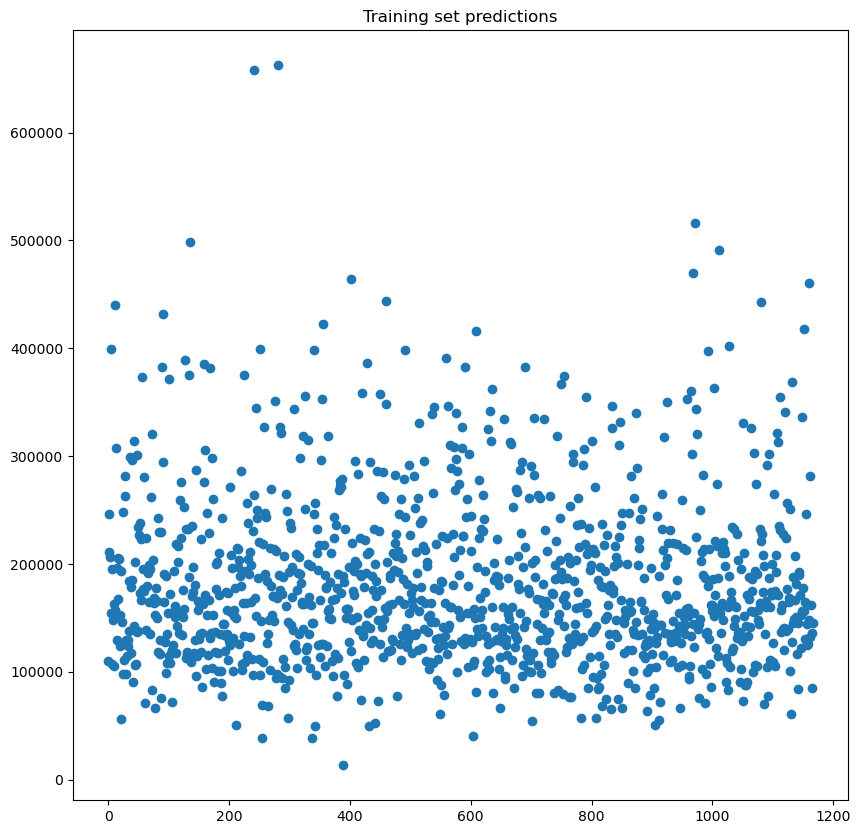

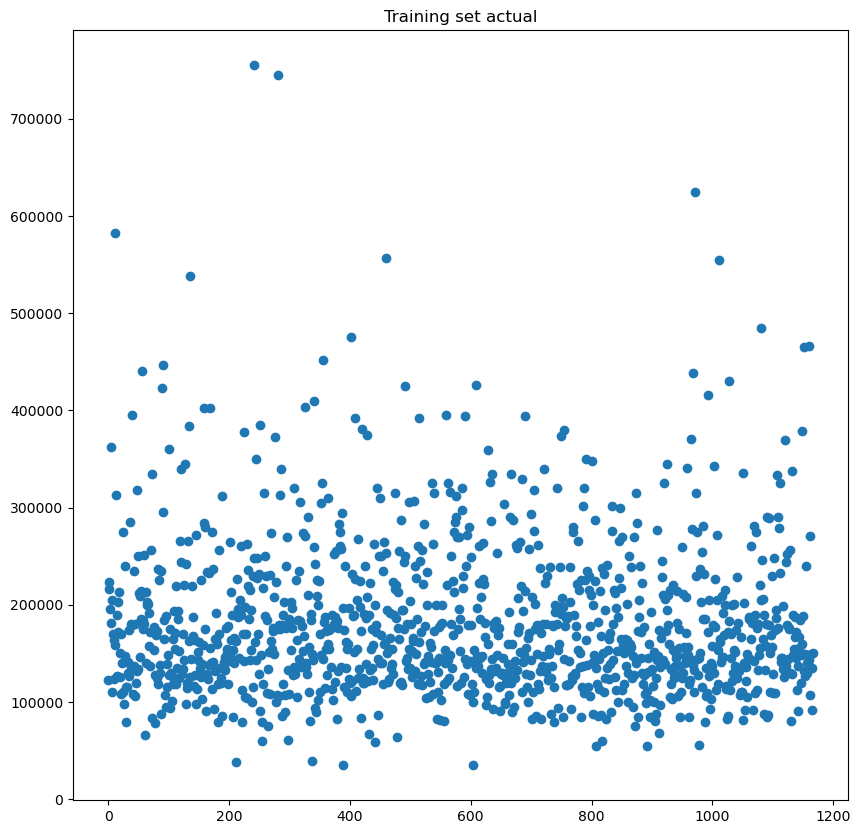

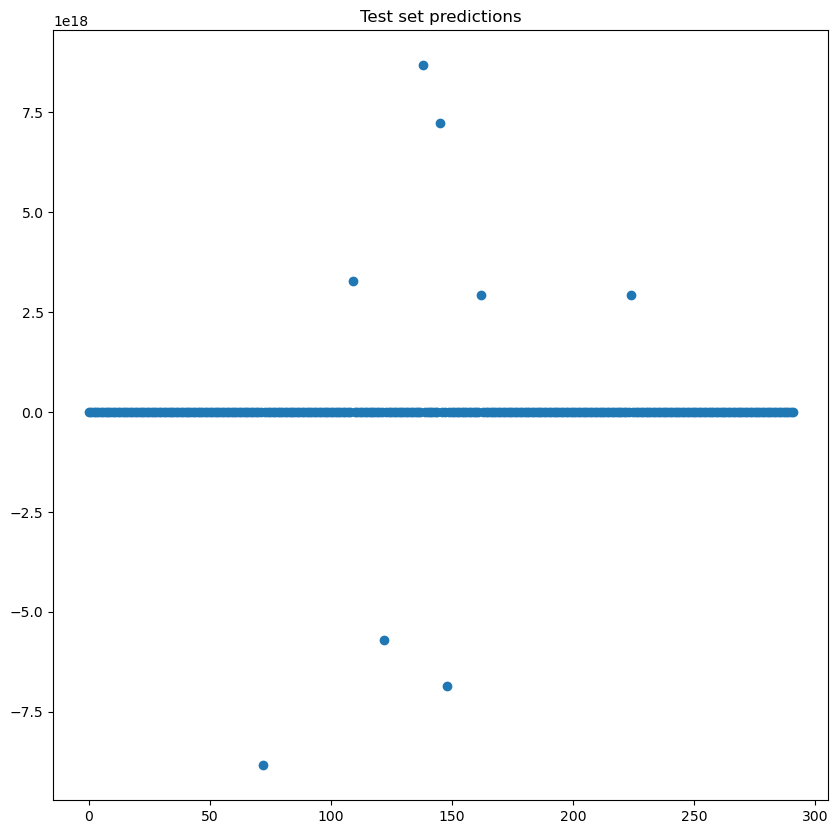

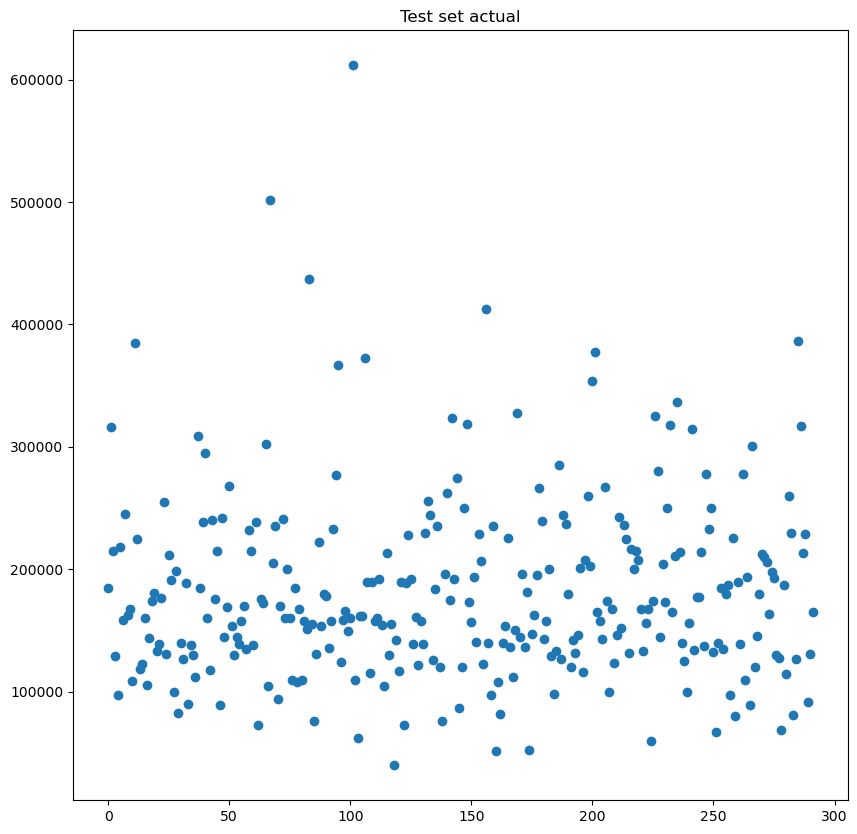

In [446]:
plot_predictions_to_actual(linearRegression, X_train, y_train, X_test, y_test)

OLS generalize very poorly, but performed well in the training set.

### Random Forest

In [448]:
from sklearn.ensemble import RandomForestRegressor

In [449]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

In [ ]:
print_performance_metrics(rf_regressor, X_train, y_train, X_test, y_test)

R^2 - train: 0.9797110053928855
R^2 - test: 0.8882551943713333
MSE - train: 131585874.13587534
MSE - test: 627247785.9200082
MSE DIF test-train 495661911.78413284


Does preform good, but seems a bit overfittet

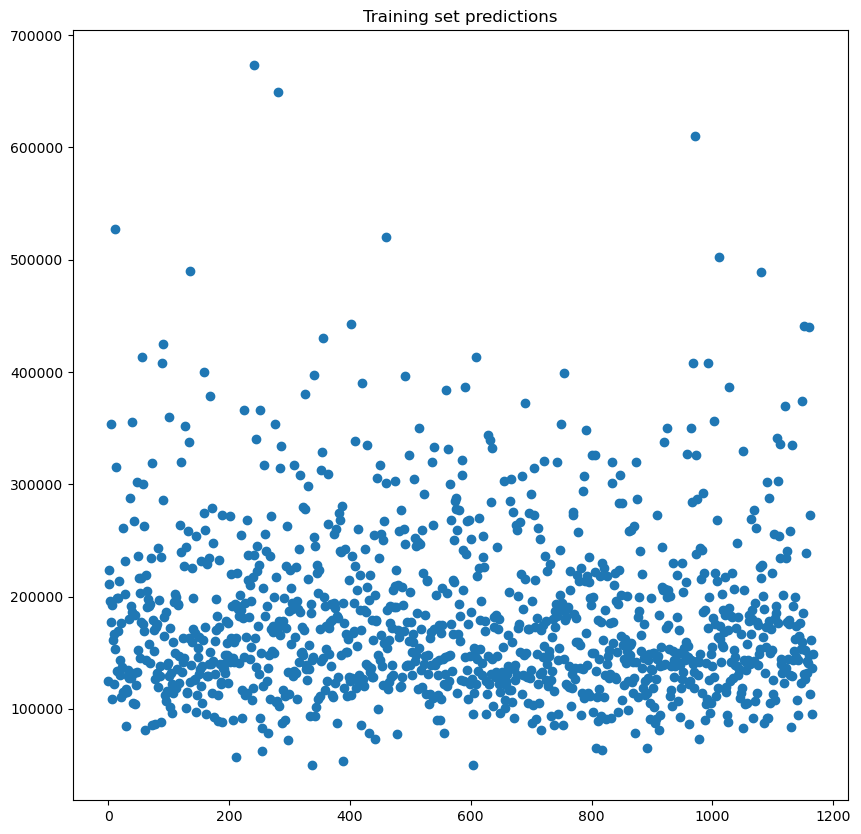

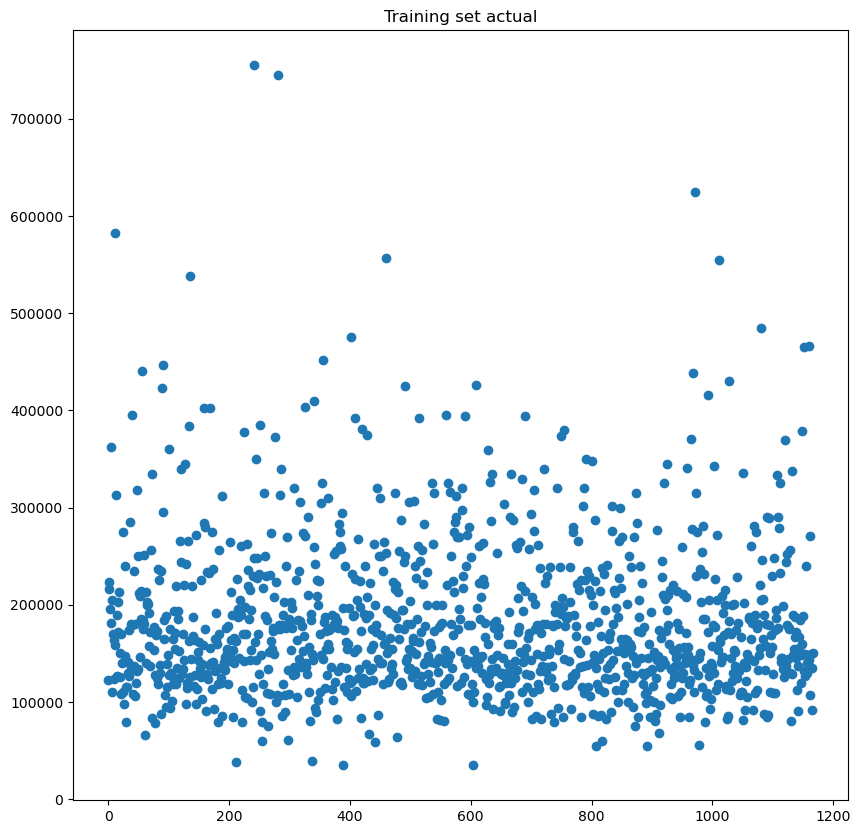

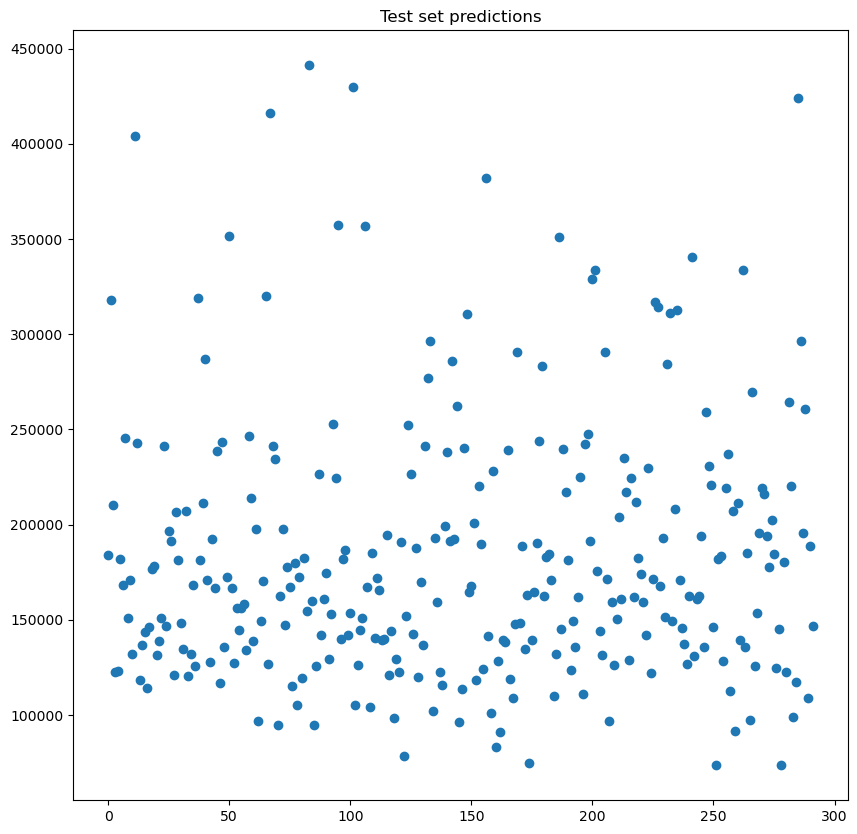

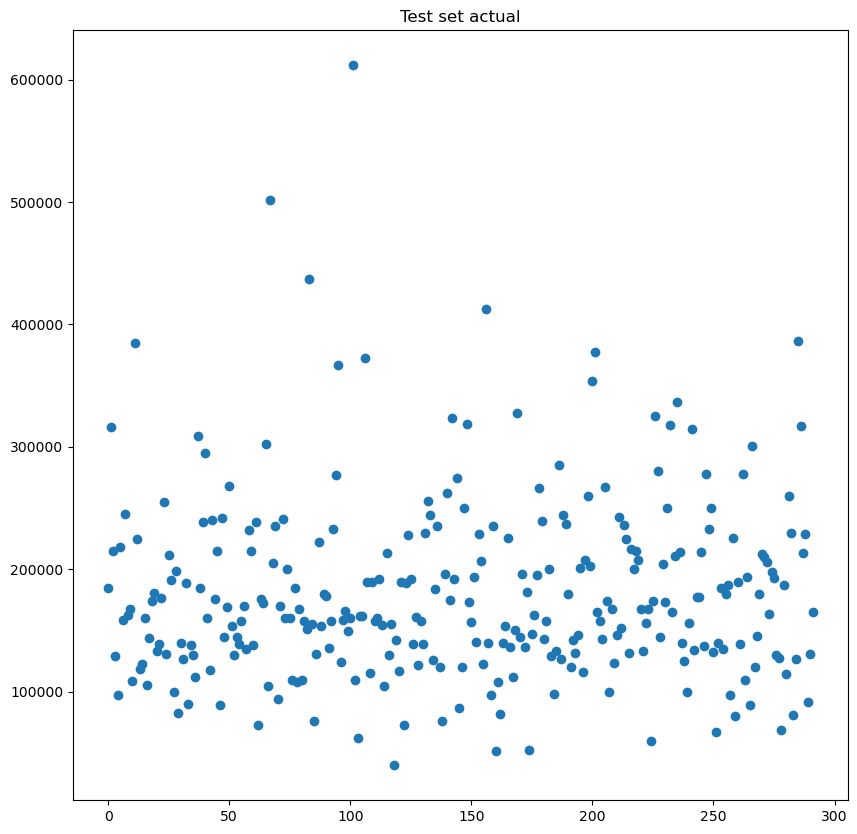

In [ ]:
plot_predictions_to_actual(rf_regressor, X_train, y_train, X_test, y_test)

### Gradient Boosted Tree

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
print_performance_metrics(xgb, X_train, y_train, X_test, y_test)

R^2 - train: 0.9997945519767718
R^2 - test: 0.9086130055249595
MSE - train: 1332449.3524429074
MSE - test: 512974984.59872836
MSE DIF test-train 511642535.24628544


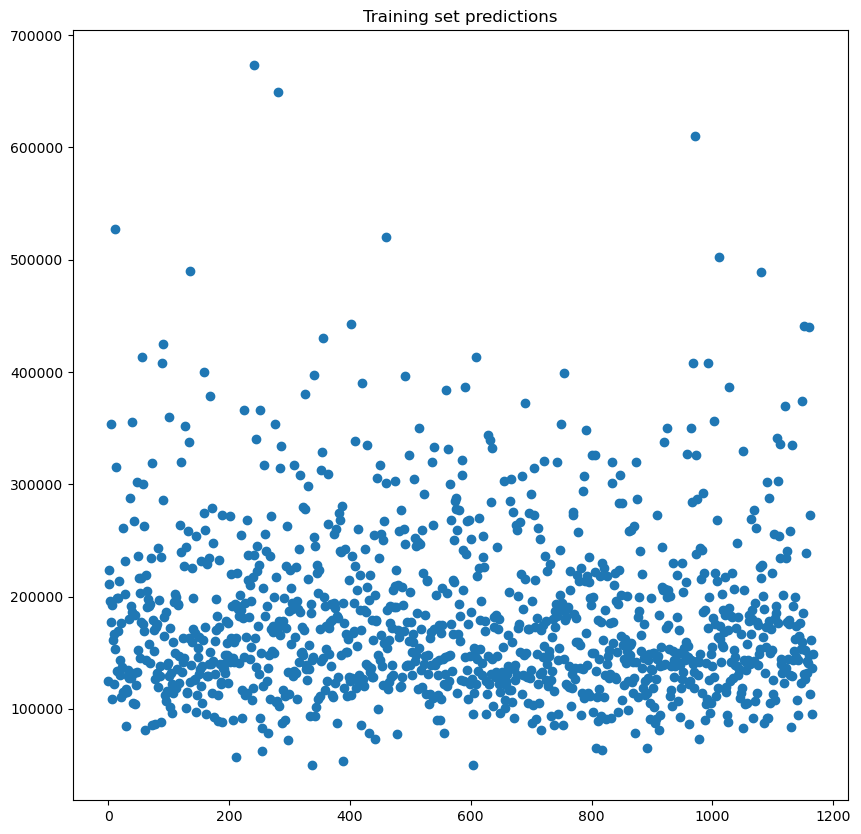

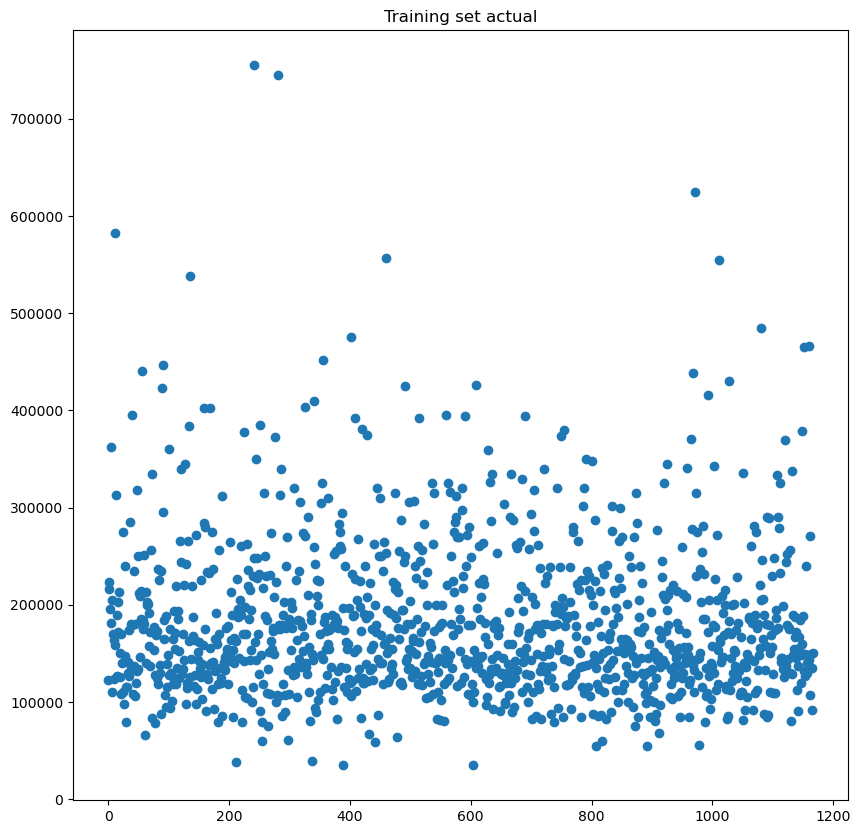

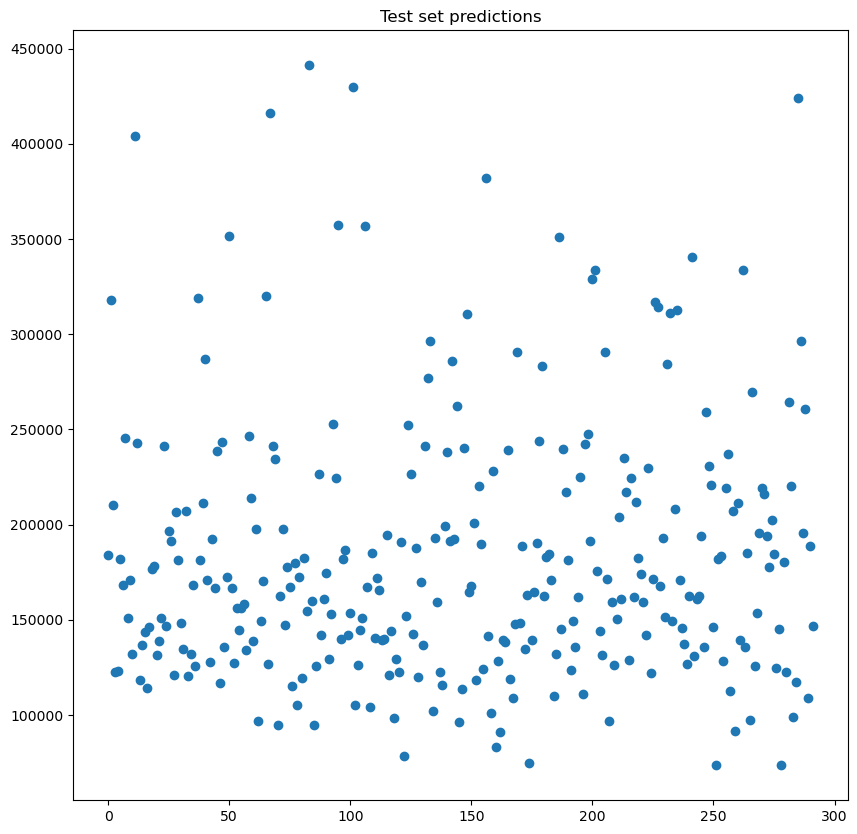

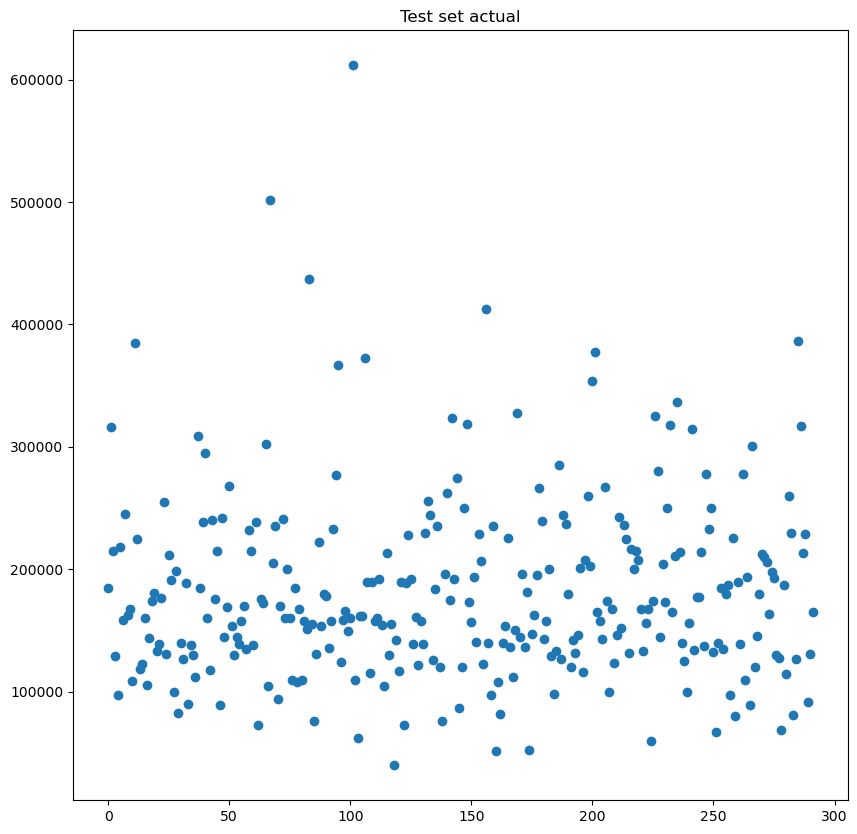

In [ ]:

plot_predictions_to_actual(rf_regressor, X_train, y_train, X_test, y_test)

Performs a bit better than the Random Forest Regressor. Still overfitted, but the MSE on the test set is lower. It seems to be generalizing better.

### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)

ElasticNet()

In [ ]:
print_performance_metrics(elastic_net, X_train, y_train, X_test, y_test)

R^2 - train: 0.9158867097853316
R^2 - test: 0.8801232464150641
MSE - train: 545523375.2913797
MSE - test: 672894170.3053068
MSE DIF test-train 127370795.0139271


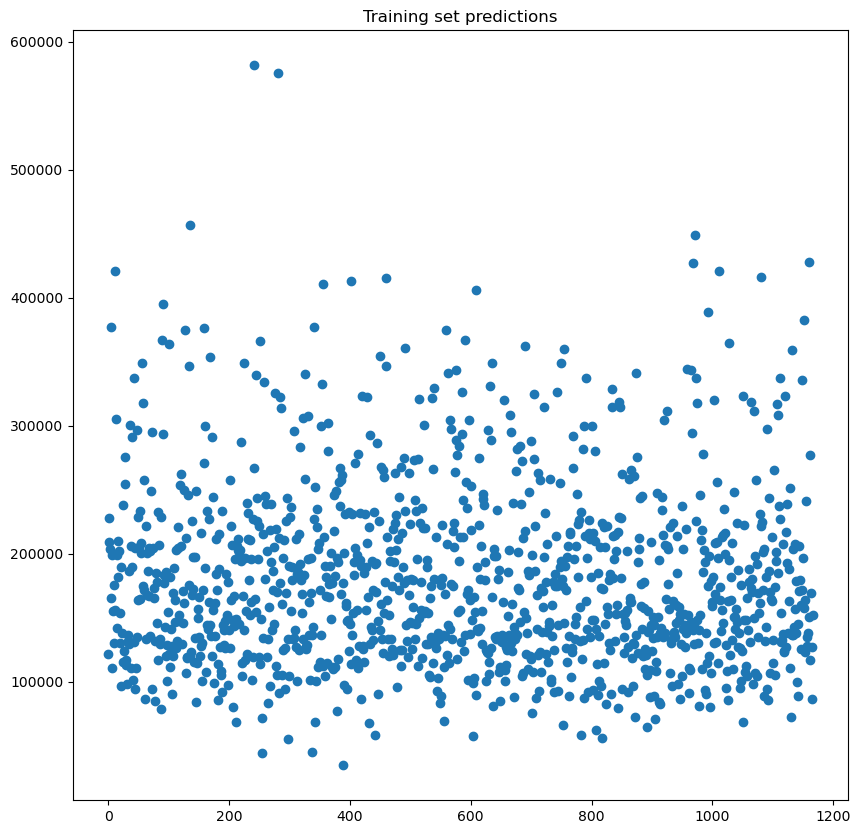

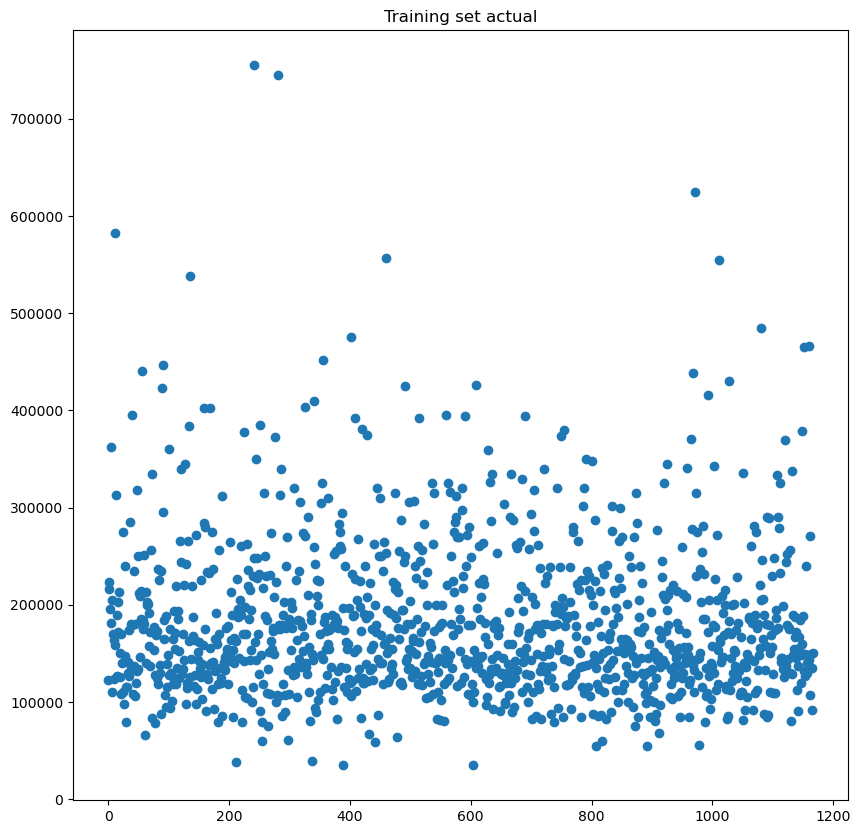

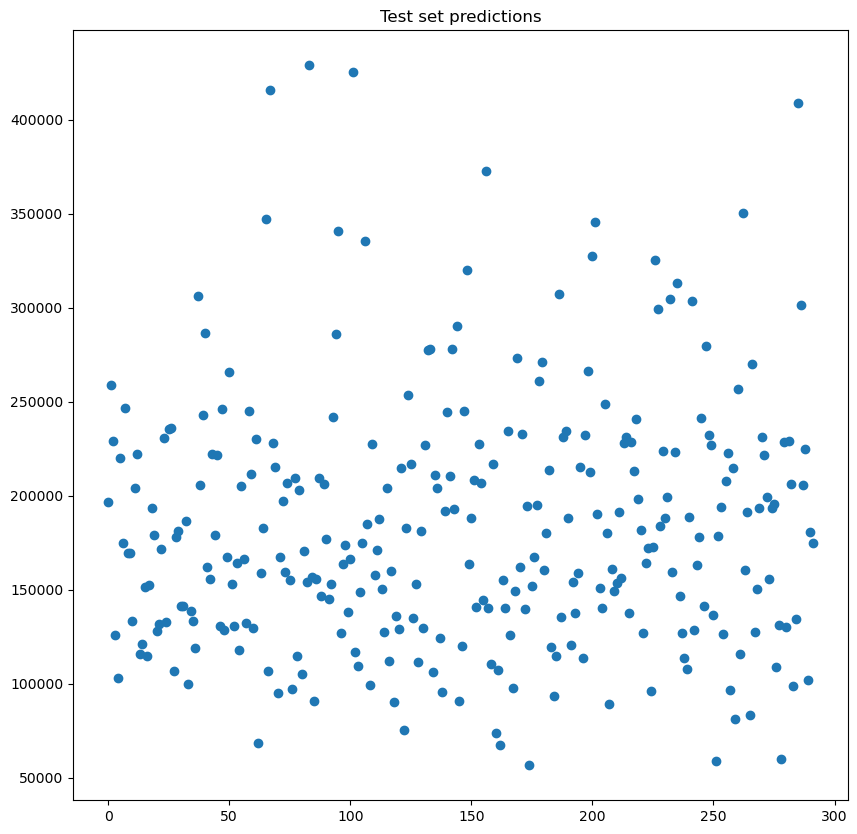

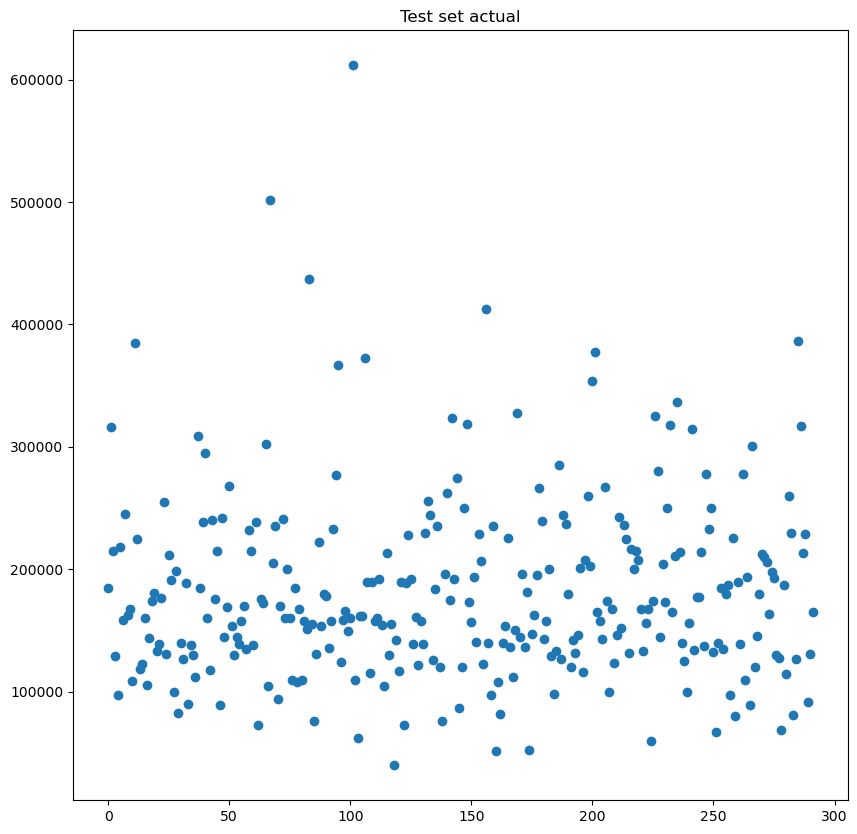

In [ ]:
plot_predictions_to_actual(elastic_net, X_train, y_train, X_test, y_test)

Performs nearly as good as the Gradient Boosted Tree and the Random Forest, but does not overfit. Generalizes well to our dataset.

### K-Nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [ ]:
warnings.filterwarnings('ignore')
print_performance_metrics(knn, X_train, y_train, X_test, y_test)

R^2 - train: 0.8170884118031712
R^2 - test: 0.7644206366571684


MSE - train: 1186287526.2444558
MSE - test: 1322357967.6380823
MSE DIF test-train 136070441.39362645


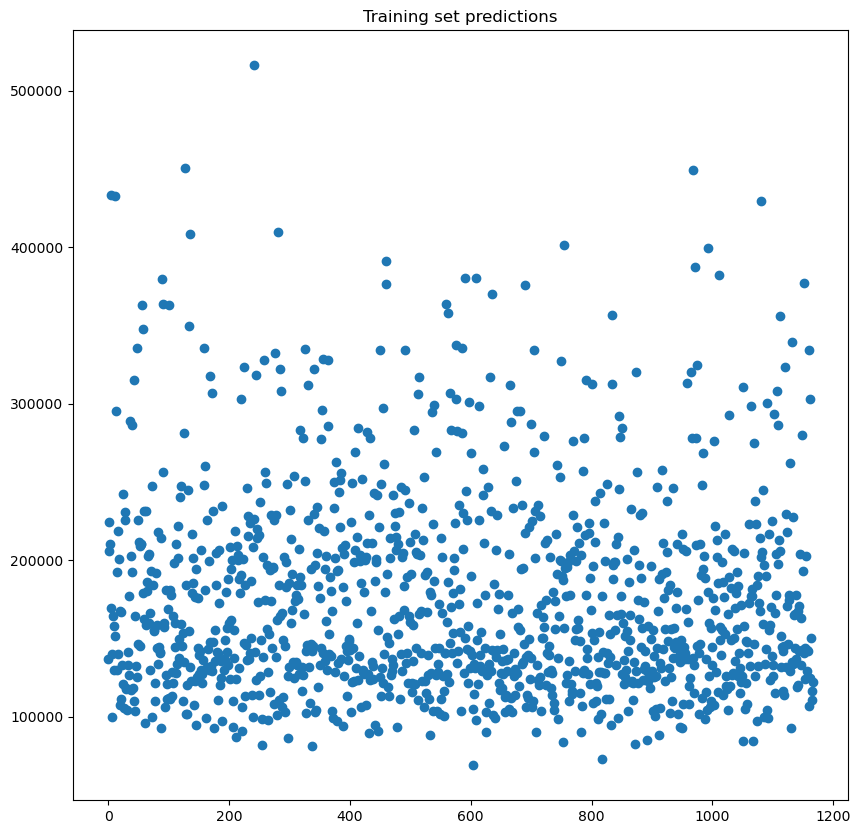

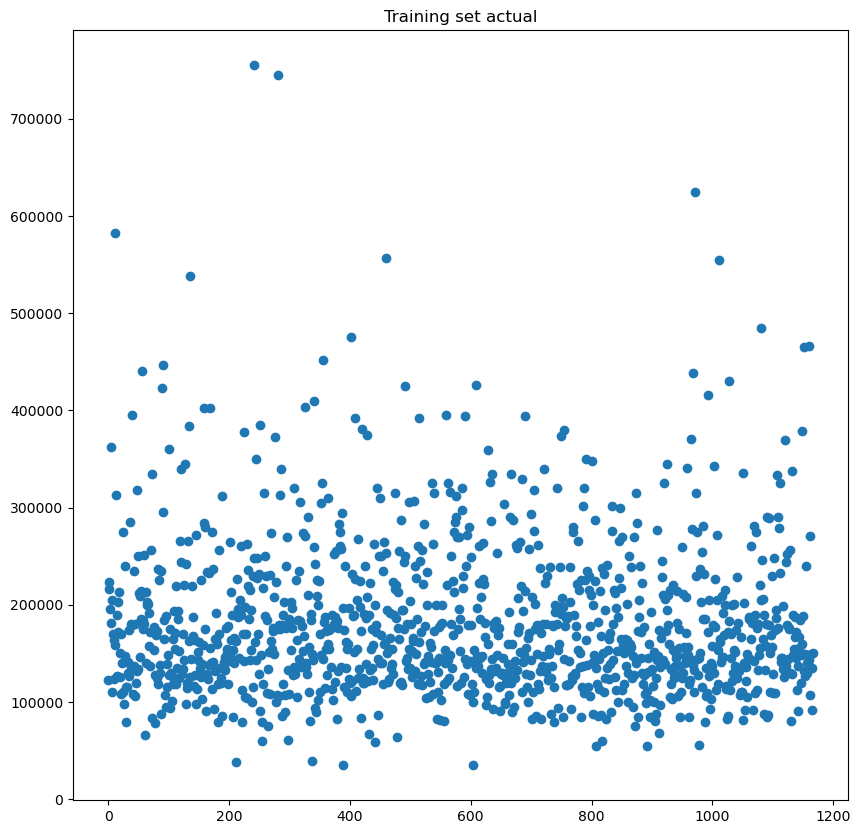

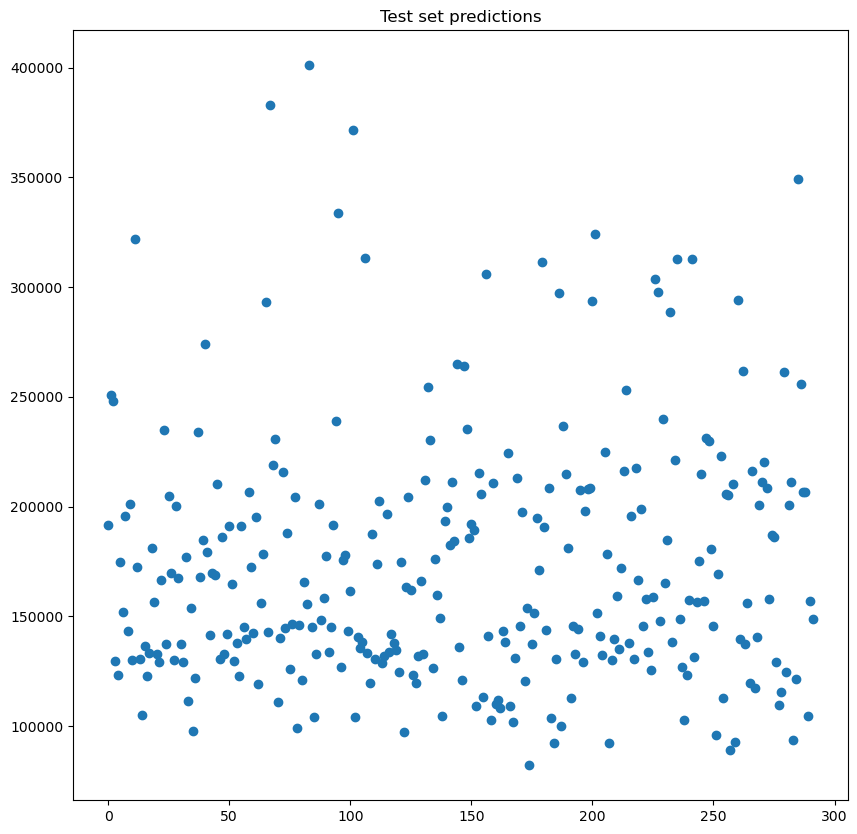

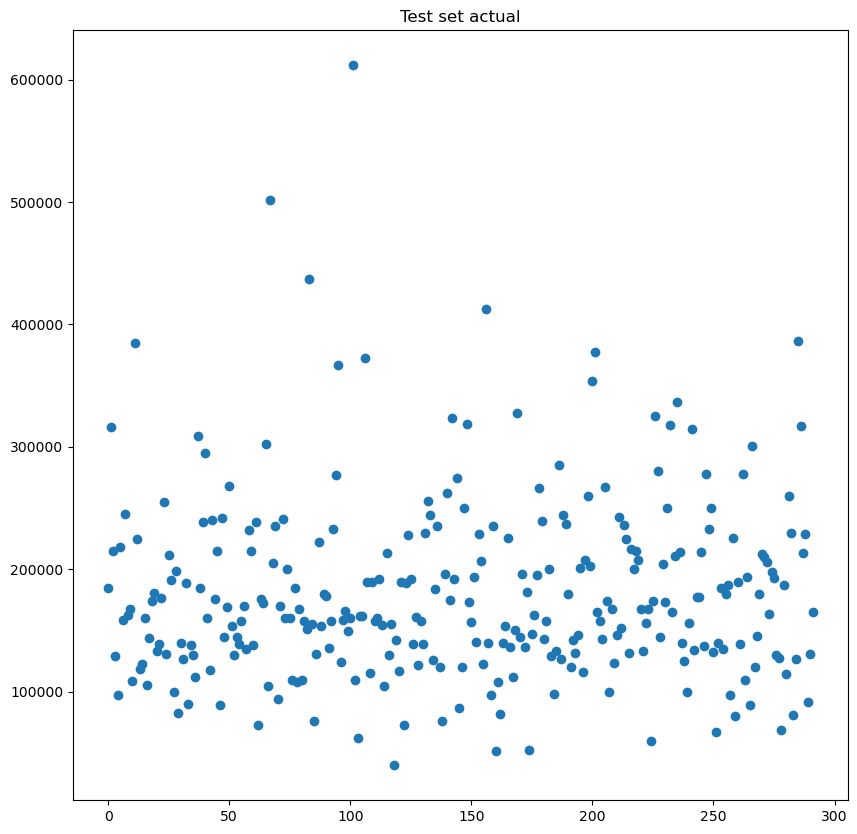

In [ ]:
plot_predictions_to_actual(knn, X_train, y_train, X_test, y_test)

### Feature Engineering and Feature Selection
All the models seem to overfit other than ElasticNet. We can try to reduce the amount of features 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=4242)
X_pca = pca.fit_transform(X=X_scaled)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=4242)

In [ ]:
pca.components_.shape

(181, 301)

In [ ]:
pca.explained_variance_ratio_

array([0.06206248, 0.02927698, 0.02472416, 0.02254029, 0.0195272 ,
       0.01760895, 0.01529077, 0.01512617, 0.01257297, 0.0117728 ,
       0.01166529, 0.01138276, 0.01087685, 0.01015258, 0.00995165,
       0.00960889, 0.009456  , 0.00919677, 0.00898765, 0.0088682 ,
       0.00867954, 0.00845735, 0.00818867, 0.00807508, 0.00793818,
       0.00786325, 0.00760689, 0.00752961, 0.00734387, 0.00729435,
       0.00717851, 0.00710287, 0.00703708, 0.0069595 , 0.00689784,
       0.00675797, 0.00665556, 0.00654708, 0.00638034, 0.00634875,
       0.0062551 , 0.00622658, 0.00615038, 0.00612208, 0.00605808,
       0.00581474, 0.0057879 , 0.00572946, 0.00565699, 0.00556104,
       0.00545374, 0.00540237, 0.00535748, 0.00530559, 0.00527367,
       0.00520196, 0.00517485, 0.00504592, 0.00502688, 0.00497059,
       0.0049118 , 0.00483997, 0.00483694, 0.00479431, 0.00474076,
       0.00464304, 0.00460744, 0.00458659, 0.00451013, 0.00450755,
       0.00449142, 0.00442642, 0.00436571, 0.0043182 , 0.00430

### Round 2
Analyzing the most important variables for each algortihm. Since the models are overfitting, we will first try to tweak the parameters that regularize the models, in an attempt to reduce the overfitting. E.g. lower max_depth for Decision Tree based models, increase alpha/lamda for ElasticNet etc.

OLS has no hyperparameters, so we do not need to train a new OLS model.

First we check performance after doing the PCA and then we try analyze which hyperparamters have the most impact on the model.

### OLS

In [ ]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression()

linearRegression.fit(X_train_pca,y_train)

LinearRegression()

In [ ]:
print_performance_metrics(linearRegression, X_train_pca, y_train, X_test_pca, y_test)

R^2 - train: 0.9185501455938785
R^2 - test: 0.17396746993992374
MSE - train: 528249452.3662118
MSE - test: 4636699421.177986
MSE DIF test-train 4108449968.8117743


The $R^2$ seem to be positive again.

### Random Forest

In [ ]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_pca,, y_train)

RandomForestRegressor()

In [ ]:
print_performance_metrics(rf_regressor, X_train_pca,, y_train, X_test_pca, y_test)

R^2 - train: 0.9699213844496537
R^2 - test: 0.8838483888953587
MSE - train: 195077232.58999616
MSE - test: 651984139.097539
MSE DIF test-train 456906906.5075428


### Gradient Boosted Tree

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train_pca,, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
print_performance_metrics(xgb, X_train_pca,  y_train, X_test, y_test)

R^2 - train: 0.9999999934977784
R^2 - test: 0.8628795554492971
MSE - train: 42.170670980863726
MSE - test: 769686740.828079
MSE DIF test-train 769686698.657408


The PCA did not seem to improve the performance or reduce the overfitting. It actually made increased the MSE on the test set.